# Introduction

The **National Health and Nutrition Examination Survey Data I Epidemiologic Follow-up Study (NHEFS)** is a longitudinal study that followed participants from the first National Health and Nutrition Examination Survey (NHANES I) conducted between 1971-1975.


The original purpose was to investigate the relationships between clinical, nutritional, and behavioral factors assessed in the early 1970s and subsequent morbidity, mortality, and hospital utilization

# Data Dictionary


| Variable Name | Description | Type / Coding |
|---------------|-------------|---------------|
| `seqn` | Respondent's sequence number (ID) | Numeric (Integer) |
| `qsmk` | Treatment: Quit smoking between 1971–1975 and 1982–1984. | Binary (1=Yes, 0=No/Continue Smoking) |
| `wt82_71` | Outcome: Change in weight (kg) between baseline and follow-up. | Numeric (Continuous) |
| `death` | Death status by 1982–1984 follow-up. | Binary (1=Died, 0=Survived) |
| `censored` | Indicates if the outcome is missing (e.g., subject died or lost to follow-up). | Binary |
| `sex` | Sex of the respondent. | Binary (1=Male, 0=Female) |
| `race` | Race of the respondent. | Binary/Categorical |
| `age` | Age (years) at baseline. | Numeric (Continuous) |
| `school` | Years of education. | Numeric (Integer) |
| `income` | Income at baseline. | Numeric (Continuous) |
| `smokeyrs` | Years of smoking at baseline. | Numeric (Integer) |
| `smokeintensity` | Cigarettes smoked per day at baseline. | Numeric (Integer) |
| `exercise` | Level of exercise at baseline. | Binary/Categorical |
| `active` | Level of physical activity at baseline. | Binary/Categorical |
| `wt71` | Weight (kg) at baseline. | Numeric (Continuous) |

# Causal Question

We're interested to find the cauality behind this question:

Does quitting smoking cause weight gain?

The dataset is rich and you can ask other questions as well, such as:
  - Does exercise affect weight?
  - Does education affect smoking cessation?

  But, we'll focus on the first question for simplicity!


In [1]:
#### Loading and Exploring the dataset ####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
url = "https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv"
nhefs = pd.read_csv(url)

print("Dataset shape:", nhefs.shape)
print("\nColumns:", nhefs.columns.tolist())

Dataset shape: (1629, 64)

Columns: ['seqn', 'qsmk', 'death', 'yrdth', 'modth', 'dadth', 'sbp', 'dbp', 'sex', 'age', 'race', 'income', 'marital', 'school', 'education', 'ht', 'wt71', 'wt82', 'wt82_71', 'birthplace', 'smokeintensity', 'smkintensity82_71', 'smokeyrs', 'asthma', 'bronch', 'tb', 'hf', 'hbp', 'pepticulcer', 'colitis', 'hepatitis', 'chroniccough', 'hayfever', 'diabetes', 'polio', 'tumor', 'nervousbreak', 'alcoholpy', 'alcoholfreq', 'alcoholtype', 'alcoholhowmuch', 'pica', 'headache', 'otherpain', 'weakheart', 'allergies', 'nerves', 'lackpep', 'hbpmed', 'boweltrouble', 'wtloss', 'infection', 'active', 'exercise', 'birthcontrol', 'pregnancies', 'cholesterol', 'hightax82', 'price71', 'price82', 'tax71', 'tax82', 'price71_82', 'tax71_82']


In [2]:
### Null and duplicate values check ###

print(f"Number of null values in each column:\n{nhefs.isnull().sum()}")
print()
print(f"Number of duplicate rows: {nhefs.duplicated().sum()}")

Number of null values in each column:
seqn             0
qsmk             0
death            0
yrdth         1311
modth         1307
              ... 
price82         92
tax71           92
tax82           92
price71_82      92
tax71_82        92
Length: 64, dtype: int64

Number of duplicate rows: 0


Our Treatment feature here is "qsmk" (quit smoking) and the Outcome that we're interested in is "wt82_71" (weight change)


***Let's figure out our confounders:***

A ***Confounder*** is a feauture or a variable if it affects both the treatment and also te outcome.

For example:


- Age: Age affects both the smoking urge and the metabolism. (Metabolism slows down as we age!)
- Sex: Sex affects both, hormonal differences and cultural norms, etc.
- Income: Weak causation and it is debatable to include it in the confounder list.
- Death: Not a confounder. If a person is dead we don't get valuable info to find out our treatment, so no!

To figure out the confounders you need to have the domain knowledge and need to consult the SME's, etc.




In [3]:
### Selecting the Confounders ###

# Select variables that matter for causality
# Treatment: qsmk (quit smoking: 0=no, 1=yes)
# Outcome: wt82_71 (weight change from 1982-1971)
# Confounders: variables that affect BOTH treatment and outcome

key_vars = [
    'seqn',          # ID
    'qsmk',          # TREATMENT: Quit smoking
    'wt82_71',       # OUTCOME: Weight change (kg)
    'sex',           # Confounder: affects smoking & weight
    'age',           # Confounder: age affects both
    'race',          # Confounder: sociodemographic
    'education',     # Confounder: sociodemographic
    'wt71',          # Confounder: baseline weight
    'smokeintensity',# Confounder: how much they smoked
    'smokeyrs',      # Confounder: years of smoking
    'exercise',      # Confounder: physical activity
    'active'         # Confounder: daily activity level
]

df = nhefs[key_vars].copy()
print("Simplified dataset:", df.shape)


Simplified dataset: (1629, 12)


Missing values in each column:
seqn               0
qsmk               0
wt82_71           63
sex                0
age                0
race               0
education          0
wt71               0
smokeintensity     0
smokeyrs           0
exercise           0
active             0
dtype: int64


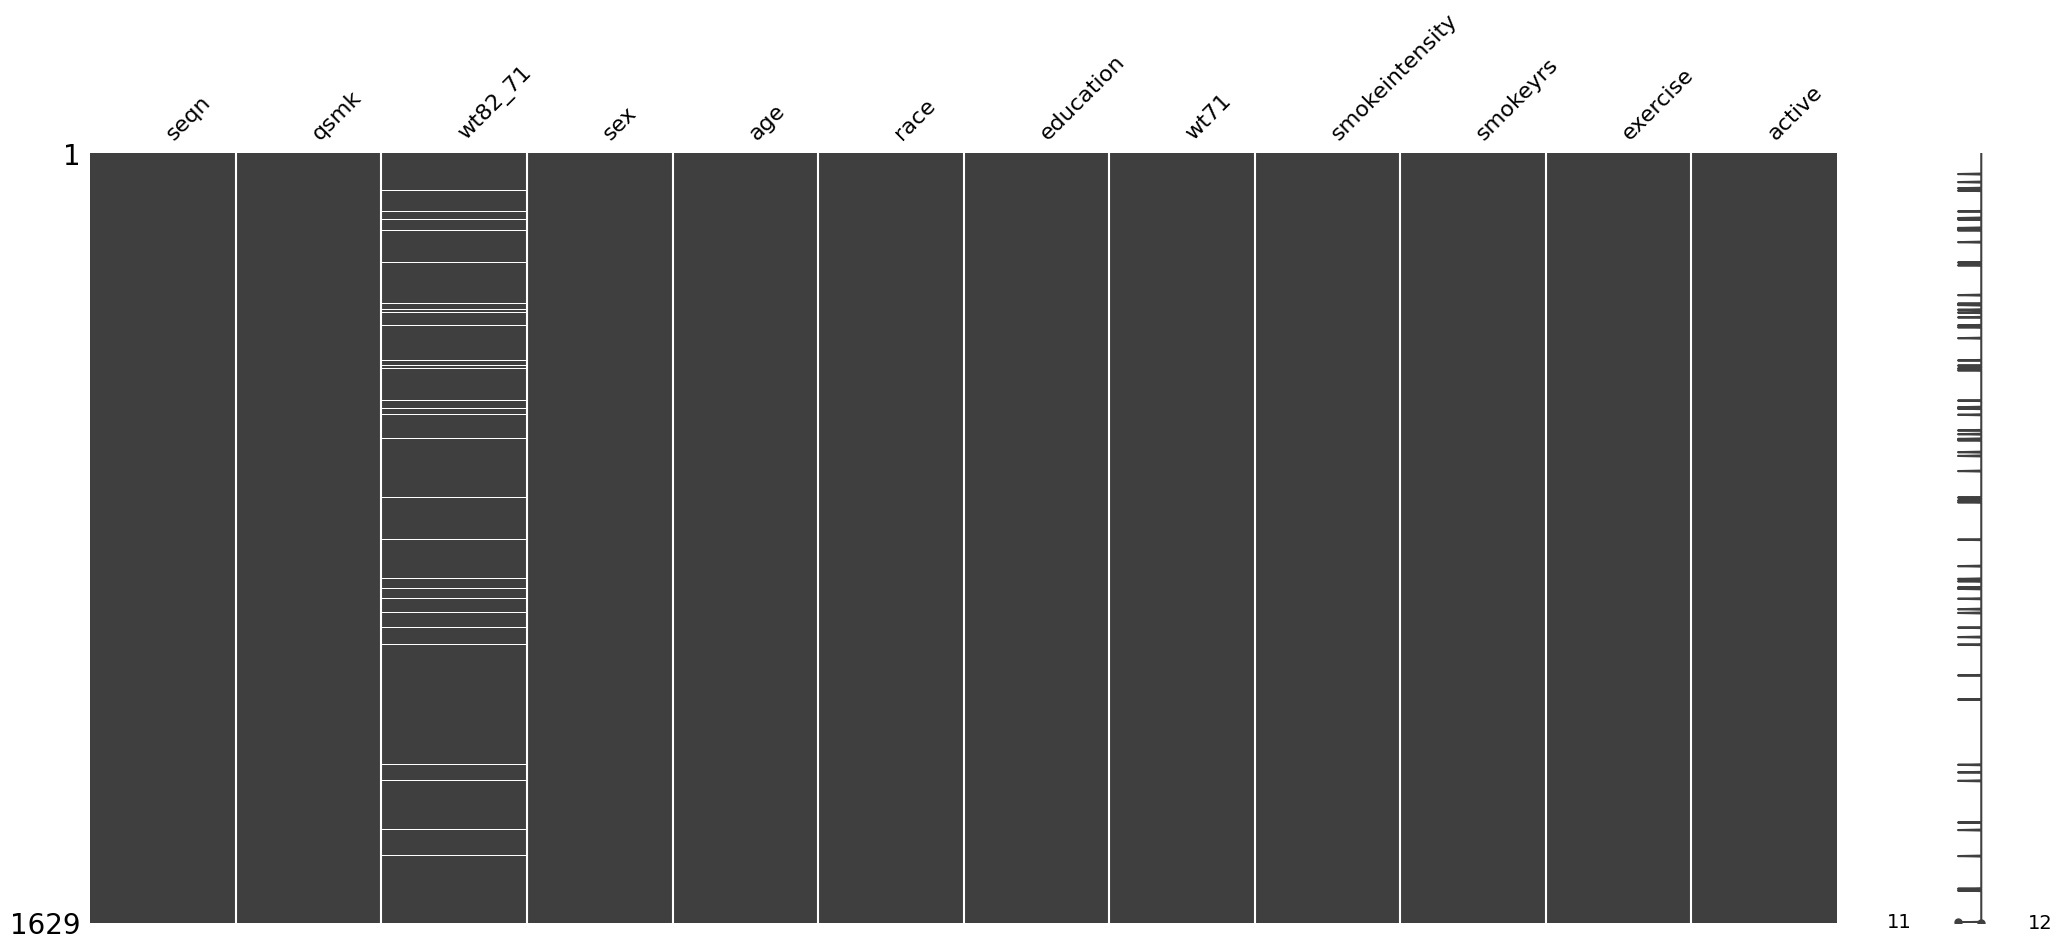

Observations after dropping missing: 1566


In [4]:
### Handling missing data ####

print(f"Missing values in each column:\n{df.isnull().sum()}")

# Visualize missingness
import missingno as msno
msno.matrix(df)
plt.show()

df_complete = df.dropna()
print(f"Observations after dropping missing: {len(df_complete)}")

Quit smoking distibution:
qsmk
0    1163
1     403
Name: count, dtype: int64

Weight change distribution:
count    1566.000000
mean        2.638300
std         7.879913
min       -41.280470
25%        -1.478399
50%         2.603811
75%         6.689581
max        48.538386
Name: wt82_71, dtype: float64


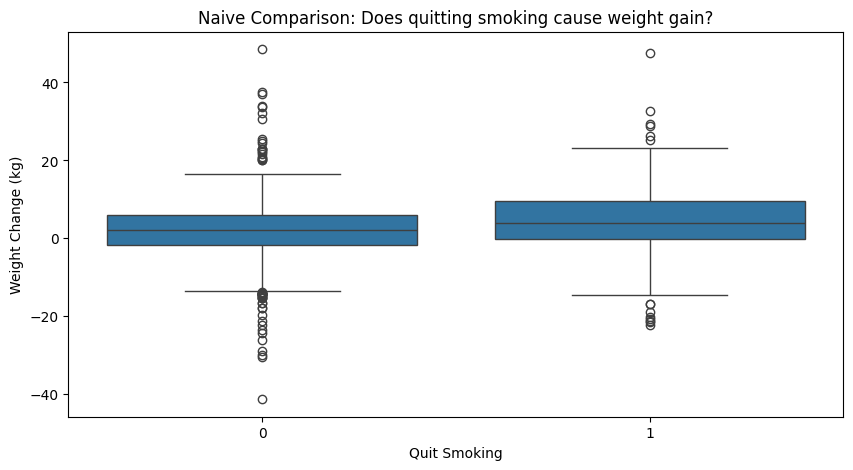


Naive effect: 2.54 kg


In [5]:
### Getting the distributions ###

##Exploring treatment
print("Quit smoking distibution:")
print(df_complete['qsmk'].value_counts())

## Explore outcome
print("\nWeight change distribution:")
print(df_complete['wt82_71'].describe())

## Plot treatment vs outcome (naive comparison)
plt.figure(figsize=(10, 5))
sns.boxplot(x='qsmk', y='wt82_71', data=df_complete)
plt.xlabel('Quit Smoking')
plt.ylabel('Weight Change (kg)')
plt.title('Naive Comparison: Does quitting smoking cause weight gain?')
plt.show()

# Calculate naive difference
naive_effect = df_complete.groupby('qsmk')['wt82_71'].mean().diff().iloc[-1]
print(f"\nNaive effect: {naive_effect:.2f} kg")

This visualization does not establish causation. It only shows an association.
Meaning, though the data shows that people who quit smoking gained weight 2.5 kg more than non-quitters, does this mean smoking causes that weight gain? We don't have a solid answer, it could be due to confounding.

The difference of 2.54 kg is the simple observed difference in means. It is considered "naive" because it does not account for confounding variables like age, sex, baseline weight, or physical activity.

In [6]:
# Check if confounders differ between treated/control
confounders = ['age', 'sex', 'race', 'education', 'wt71',
               'smokeintensity', 'smokeyrs', 'exercise', 'active']

print("Are confounders balanced?")
for var in confounders:
    treated = df_complete[df_complete['qsmk']==1][var].mean()
    control = df_complete[df_complete['qsmk']==0][var].mean()
    print(f"{var}: Treated={treated:.2f}, Control={control:.2f}")

Are confounders balanced?
age: Treated=46.17, Control=42.79
sex: Treated=0.45, Control=0.53
race: Treated=0.09, Control=0.15
education: Treated=2.79, Control=2.69
wt71: Treated=72.35, Control=70.30
smokeintensity: Treated=18.60, Control=21.19
smokeyrs: Treated=26.03, Control=24.09
exercise: Treated=1.25, Control=1.18
active: Treated=0.69, Control=0.63


Our Naive comparison is **Biased**.

- Age: Quitters has mean age of 46.17 and non-quitters has the mean age of 42.79. Older people gain more weight because of low metabolism even without quitting.

The direction of bias is higher (overestimates) the causal effect of quitting.

- Baseline weight wt71: Heavier people might be more motivated to quit or vice-versa and we've no idea as the direction of bias can go either way.

- Smoking Intensity: Heavier smokers have more hunger suppression from nicotine and when they quit, they experience bigger "rebound" weight gain.
It underestimates the effect of quitting for heavy smokers.

- Smoking Years: Longer smoking years causes nicotine adaption and quitting after long time usage causes metabolic changes.

Unclear direction of bias

- Sex: Women could gain more weight after quitting due to hormonal changes. Also quitters have more women.

Bias direction likely makes quitting look worse.

- Education: Groups are similar in education.

- Exercise & Activity: More active people might gain less weight naturally and here, quitters are slightly more active.

Direction of bias: Small bias towards zero, underestimates quitting effect.

Overall bias of the naive estimate:

2 features which overestimate and 2 features which underestimate and 2 more with unclear direction.

We need to balance statistically

/tmp/ipython-input-732969076.py:147: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-732969076.py:147: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


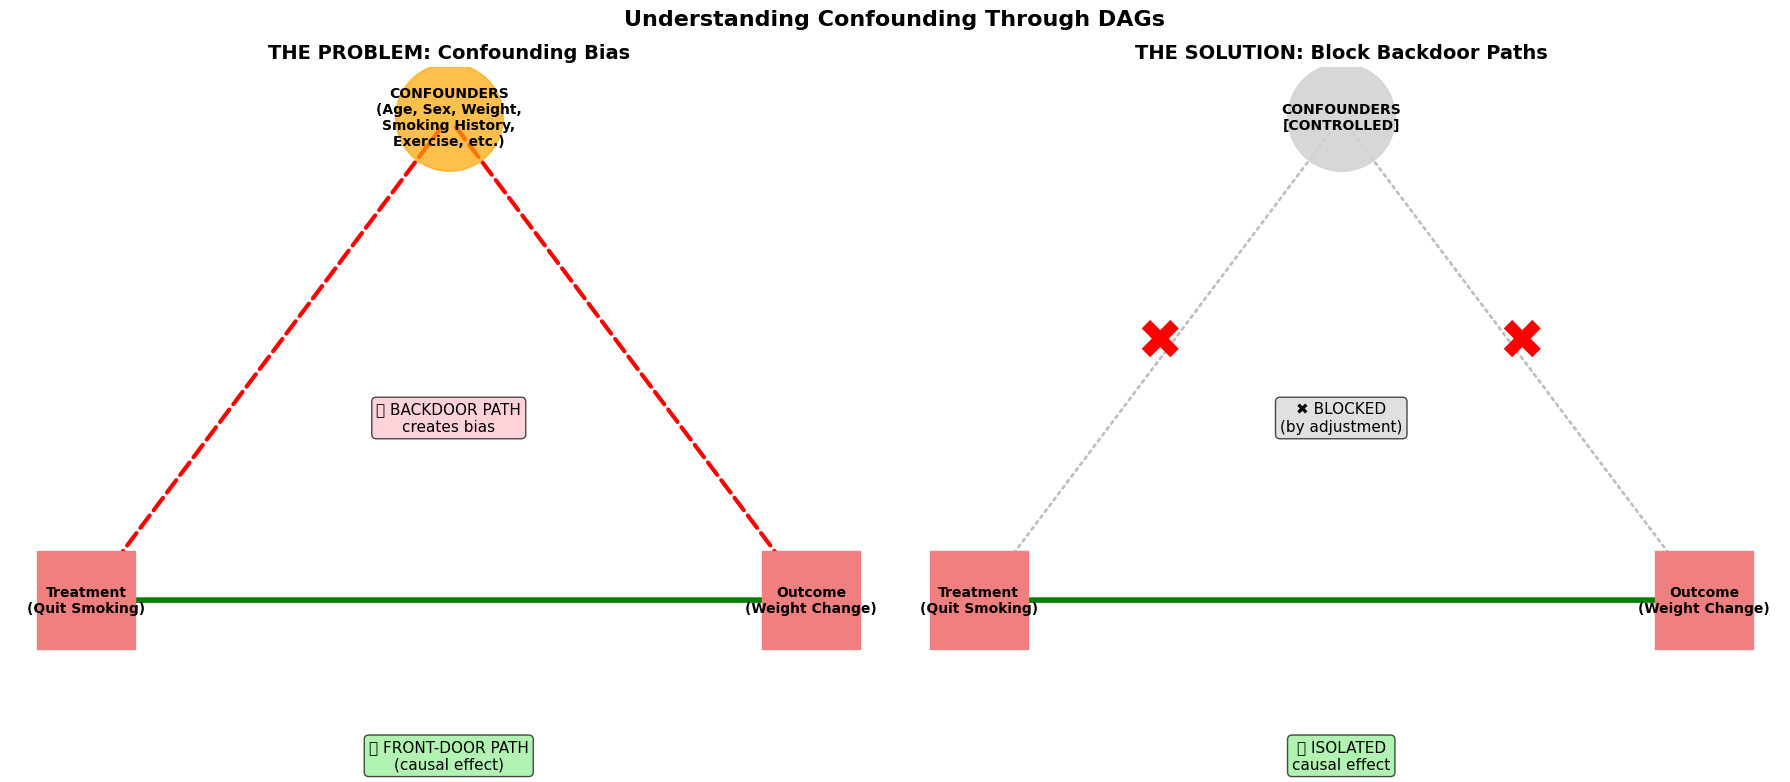

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ========== LEFT PLOT: The Problem (Backdoor Paths) ==========
G1 = nx.DiGraph()

treatment = 'Treatment\n(Quit Smoking)'
outcome = 'Outcome\n(Weight Change)'
confounders_label = 'CONFOUNDERS\n(Age, Sex, Weight,\nSmoking History,\nExercise, etc.)'

G1.add_edges_from([
    (confounders_label, treatment),
    (confounders_label, outcome),
    (treatment, outcome)
])

pos1 = {
    treatment: (0, 0),
    outcome: (4, 0),
    confounders_label: (2, 2)
}

axes[0].set_title('THE PROBLEM: Confounding Bias', fontsize=14, fontweight='bold')

# Draw
nx.draw_networkx_nodes(G1, pos1, ax=axes[0],
                       nodelist=[treatment, outcome],
                       node_color='lightcoral',
                       node_size=5000,
                       node_shape='s')

nx.draw_networkx_nodes(G1, pos1, ax=axes[0],
                       nodelist=[confounders_label],
                       node_color='orange',
                       node_size=6000,
                       alpha=0.7)

# Causal path
nx.draw_networkx_edges(G1, pos1, ax=axes[0],
                       edgelist=[(treatment, outcome)],
                       edge_color='green',
                       width=4,
                       arrows=True,
                       arrowsize=25)

# Backdoor paths
nx.draw_networkx_edges(G1, pos1, ax=axes[0],
                       edgelist=[(confounders_label, treatment),
                                (confounders_label, outcome)],
                       edge_color='red',
                       width=3,
                       arrows=True,
                       arrowsize=25,
                       style='dashed')

nx.draw_networkx_labels(G1, pos1, ax=axes[0],
                       font_size=10,
                       font_weight='bold')

# Add text annotation
axes[0].text(2, 0.7, '❌ BACKDOOR PATH\ncreates bias',
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='pink', alpha=0.7))

axes[0].text(2, -0.7, '✅ FRONT-DOOR PATH\n(causal effect)',
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

axes[0].axis('off')

# ========== RIGHT PLOT: The Solution (Blocking Backdoor) ==========
G2 = nx.DiGraph()

confounders_blocked = 'CONFOUNDERS\n[CONTROLLED]'

G2.add_edges_from([
    (confounders_blocked, treatment),
    (confounders_blocked, outcome),
    (treatment, outcome)
])

pos2 = {
    treatment: (0, 0),
    outcome: (4, 0),
    confounders_blocked: (2, 2)
}

axes[1].set_title('THE SOLUTION: Block Backdoor Paths', fontsize=14, fontweight='bold')

# Draw
nx.draw_networkx_nodes(G2, pos2, ax=axes[1],
                       nodelist=[treatment, outcome],
                       node_color='lightcoral',
                       node_size=5000,
                       node_shape='s')

nx.draw_networkx_nodes(G2, pos2, ax=axes[1],
                       nodelist=[confounders_blocked],
                       node_color='lightgray',
                       node_size=6000,
                       alpha=0.9)

# Causal path (still open)
nx.draw_networkx_edges(G2, pos2, ax=axes[1],
                       edgelist=[(treatment, outcome)],
                       edge_color='green',
                       width=4,
                       arrows=True,
                       arrowsize=25)

# Blocked backdoor paths
nx.draw_networkx_edges(G2, pos2, ax=axes[1],
                       edgelist=[(confounders_blocked, treatment),
                                (confounders_blocked, outcome)],
                       edge_color='gray',
                       width=2,
                       arrows=True,
                       arrowsize=20,
                       style='dotted',
                       alpha=0.5)

# Add "X" to show blocked paths
axes[1].text(1, 1, '✖️', fontsize=40, ha='center', color='red', fontweight='bold')
axes[1].text(3, 1, '✖️', fontsize=40, ha='center', color='red', fontweight='bold')

nx.draw_networkx_labels(G2, pos2, ax=axes[1],
                       font_size=10,
                       font_weight='bold')

axes[1].text(2, 0.7, '✖️ BLOCKED\n(by adjustment)',
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

axes[1].text(2, -0.7, '✅ ISOLATED\ncausal effect',
            fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

axes[1].axis('off')

plt.suptitle('Understanding Confounding Through DAGs',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2729101504.py:111: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2729101504.py:111: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


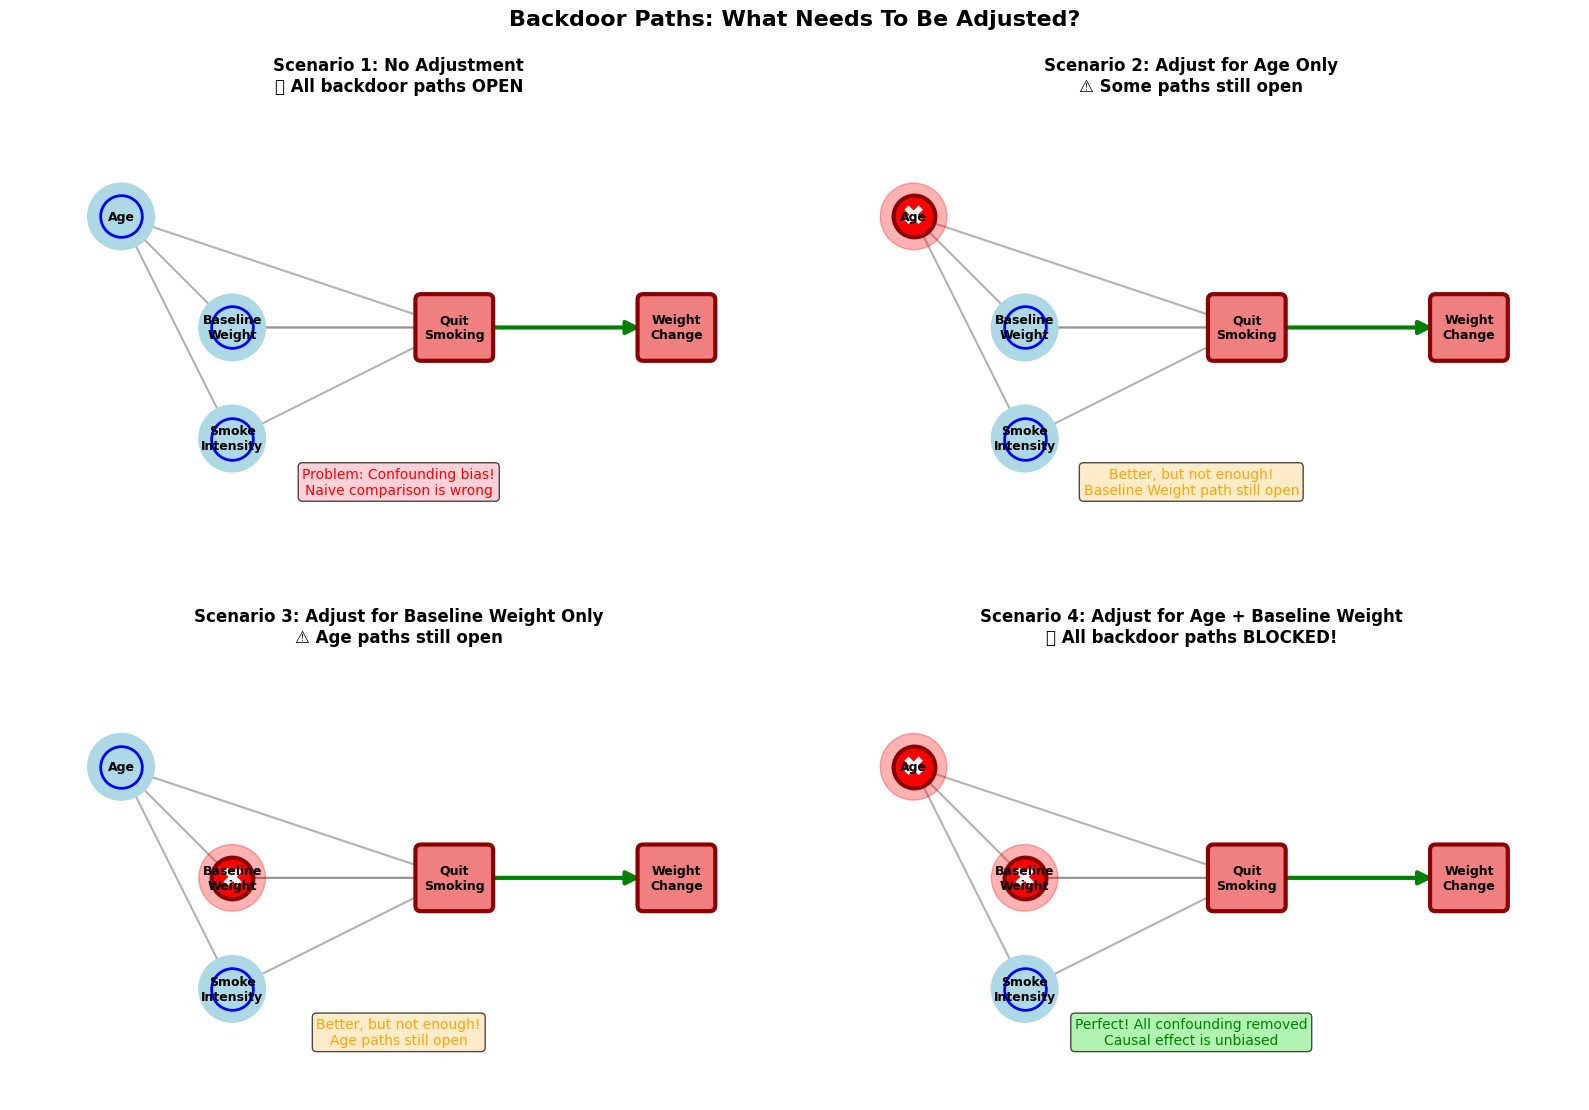

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Backdoor Paths: What Needs To Be Adjusted?',
             fontsize=16, fontweight='bold')

# Helper function to draw the DAG
def draw_dag(ax, blocked_nodes=None, title=""):
    if blocked_nodes is None:
        blocked_nodes = []

    # Node positions
    positions = {
        'Age': (1, 3),
        'Baseline\nWeight': (2, 2),
        'Smoke\nIntensity': (2, 1),
        'Quit\nSmoking': (4, 2),
        'Weight\nChange': (6, 2)
    }

    # Draw nodes
    for node, (x, y) in positions.items():
        if node in blocked_nodes:
            # Blocked nodes
            circle = plt.Circle((x, y), 0.3, color='red', alpha=0.3, zorder=2)
            ax.add_patch(circle)
            ax.plot(x, y, 'o', markersize=30, color='red', markeredgecolor='darkred',
                   markeredgewidth=3, zorder=3)
            # Add X
            ax.text(x, y, '✖', fontsize=20, ha='center', va='center',
                   color='white', fontweight='bold', zorder=4)
        elif node in ['Quit\nSmoking', 'Weight\nChange']:
            # Treatment and outcome
            rect = FancyBboxPatch((x-0.3, y-0.25), 0.6, 0.5,
                                 boxstyle="round,pad=0.05",
                                 facecolor='lightcoral', edgecolor='darkred',
                                 linewidth=3, zorder=2)
            ax.add_patch(rect)
        else:
            # Regular confounders
            circle = plt.Circle((x, y), 0.3, color='lightblue', zorder=2)
            ax.add_patch(circle)
            ax.plot(x, y, 'o', markersize=30, color='lightblue',
                   markeredgecolor='blue', markeredgewidth=2, zorder=3)

        ax.text(x, y, node, ha='center', va='center', fontsize=9,
               fontweight='bold', zorder=4)

    # Draw edges
    edges = [
        ('Age', 'Quit\nSmoking'),
        ('Age', 'Baseline\nWeight'),
        ('Age', 'Smoke\nIntensity'),
        ('Baseline\nWeight', 'Quit\nSmoking'),
        ('Baseline\nWeight', 'Weight\nChange'),
        ('Smoke\nIntensity', 'Quit\nSmoking'),
        ('Quit\nSmoking', 'Weight\nChange'),
    ]

    for start, end in edges:
        x1, y1 = positions[start]
        x2, y2 = positions[end]

        # Causal effect arrow (special)
        if start == 'Quit\nSmoking' and end == 'Weight\nChange':
            arrow = FancyArrowPatch((x1+0.3, y1), (x2-0.3, y2),
                                   arrowstyle='-|>', mutation_scale=20,
                                   color='green', linewidth=3, zorder=1)
        else:
            arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                   arrowstyle='-|>', mutation_scale=15,
                                   color='gray', linewidth=1.5, alpha=0.6, zorder=1)
        ax.add_patch(arrow)

    ax.set_xlim(0, 7)
    ax.set_ylim(0, 4)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

# Scenario 1: No adjustment
draw_dag(axes[0, 0], blocked_nodes=[],
         title='Scenario 1: No Adjustment\n❌ All backdoor paths OPEN')
axes[0, 0].text(3.5, 0.5, 'Problem: Confounding bias!\nNaive comparison is wrong',
               ha='center', fontsize=10, color='red',
               bbox=dict(boxstyle='round', facecolor='pink', alpha=0.7))

# Scenario 2: Adjust for Age only
draw_dag(axes[0, 1], blocked_nodes=['Age'],
         title='Scenario 2: Adjust for Age Only\n⚠️ Some paths still open')
axes[0, 1].text(3.5, 0.5, 'Better, but not enough!\nBaseline Weight path still open',
               ha='center', fontsize=10, color='orange',
               bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.7))

# Scenario 3: Adjust for Baseline Weight only
draw_dag(axes[1, 0], blocked_nodes=['Baseline\nWeight'],
         title='Scenario 3: Adjust for Baseline Weight Only\n⚠️ Age paths still open')
axes[1, 0].text(3.5, 0.5, 'Better, but not enough!\nAge paths still open',
               ha='center', fontsize=10, color='orange',
               bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.7))

# Scenario 4: Adjust for Age + Baseline Weight
draw_dag(axes[1, 1], blocked_nodes=['Age', 'Baseline\nWeight'],
         title='Scenario 4: Adjust for Age + Baseline Weight\n✅ All backdoor paths BLOCKED!')
axes[1, 1].text(3.5, 0.5, 'Perfect! All confounding removed\nCausal effect is unbiased',
               ha='center', fontsize=10, color='green',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

#### Regression Adjustment

Instead of comparing ALL quitters vs. ALL non-quitters (naive),
we compare people who are SIMILAR in age, weight, smoking history, etc.
but differ only in whether they quit.

Regression does this by "holding constant" the confounders.

In [9]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("METHOD 1: REGRESSION ADJUSTMENT")
print("="*70)

# ============================================
# Model 1: NAIVE (No adjustment) - BIASED
# ============================================
naive_effect = df_complete.groupby('qsmk')['wt82_71'].mean().diff().iloc[-1]

print("\n1. NAIVE COMPARISON (No confounder adjustment)")
print("-" * 70)
print(f"   Simple difference in means: {naive_effect:.2f} kg")
print("   ⚠️ WARNING: This is BIASED due to confounding!")

# ============================================
# Model 2: ADJUSTED (Full model) - UNBIASED
# ============================================
formula = '''wt82_71 ~ qsmk + age + C(sex) + C(race) + C(education) +
             wt71 + smokeintensity + smokeyrs + C(exercise) + C(active)'''

model_adjusted = smf.ols(formula, data=df_complete).fit()

print("\n2. REGRESSION ADJUSTMENT (Full confounder adjustment)")
print("-" * 70)
print(f"   Adjusted causal effect: {model_adjusted.params['qsmk']:.2f} kg")
print(f"   95% CI: [{model_adjusted.conf_int().loc['qsmk', 0]:.2f}, "
      f"{model_adjusted.conf_int().loc['qsmk', 1]:.2f}]")
print(f"   p-value: {model_adjusted.pvalues['qsmk']:.4f}")
print("   ✅ This controls for all measured confounders!")

# ============================================
# Compare naive vs. adjusted
# ============================================
print("\n3. COMPARISON: Effect of Adjustment")
print("-" * 70)
bias = naive_effect - model_adjusted.params['qsmk']
print(f"   Naive effect:     {naive_effect:.2f} kg")
print(f"   Adjusted effect:  {model_adjusted.params['qsmk']:.2f} kg")
print(f"   Confounding bias: {bias:.2f} kg ({abs(bias/naive_effect)*100:.1f}% of naive estimate)")

if abs(bias) > 0.5:
    print("\n   🚨 SUBSTANTIAL CONFOUNDING DETECTED!")
    print("   The naive comparison would have given us the WRONG answer!")
else:
    print("\n   ℹ️ Minimal confounding in this case")

# ============================================
# Statistical significance
# ============================================
print("\n4. INTERPRETATION")
print("-" * 70)
if model_adjusted.pvalues['qsmk'] < 0.001:
    sig_level = "highly significant (p < 0.001)"
elif model_adjusted.pvalues['qsmk'] < 0.01:
    sig_level = "very significant (p < 0.01)"
elif model_adjusted.pvalues['qsmk'] < 0.05:
    sig_level = "significant (p < 0.05)"
else:
    sig_level = "not statistically significant"

print(f"   Effect is {sig_level}")
print(f"\n   📊 CONCLUSION:")
print(f"   Quitting smoking causes an average weight gain of {model_adjusted.params['qsmk']:.2f} kg")
print(f"   (95% CI: {model_adjusted.conf_int().loc['qsmk', 0]:.2f} to "
      f"{model_adjusted.conf_int().loc['qsmk', 1]:.2f} kg)")

METHOD 1: REGRESSION ADJUSTMENT

1. NAIVE COMPARISON (No confounder adjustment)
----------------------------------------------------------------------
   Simple difference in means: 2.54 kg
   ⚠️ WARNING: This is BIASED due to confounding!

2. REGRESSION ADJUSTMENT (Full confounder adjustment)
----------------------------------------------------------------------
   Adjusted causal effect: 3.38 kg
   95% CI: [2.52, 4.25]
   p-value: 0.0000
   ✅ This controls for all measured confounders!

3. COMPARISON: Effect of Adjustment
----------------------------------------------------------------------
   Naive effect:     2.54 kg
   Adjusted effect:  3.38 kg
   Confounding bias: -0.84 kg (33.1% of naive estimate)

   🚨 SUBSTANTIAL CONFOUNDING DETECTED!
   The naive comparison would have given us the WRONG answer!

4. INTERPRETATION
----------------------------------------------------------------------
   Effect is highly significant (p < 0.001)

   📊 CONCLUSION:
   Quitting smoking causes an a

/tmp/ipython-input-2051177879.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete['predicted'] = model_adjusted.fittedvalues
/tmp/ipython-input-2051177879.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='qsmk', y='wt82_71', data=df_complete, ax=axes[1],
/tmp/ipython-input-2051177879.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Did Not Quit\n(Control)', 'Quit Smoking\n(Treated)'])


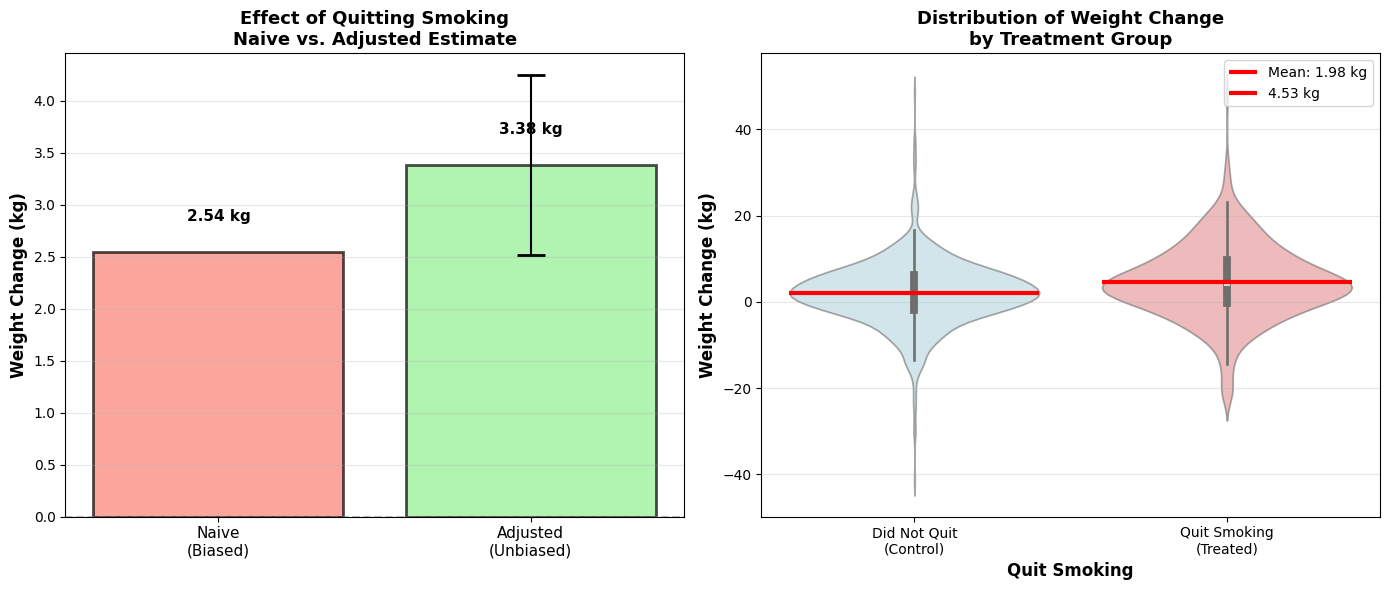

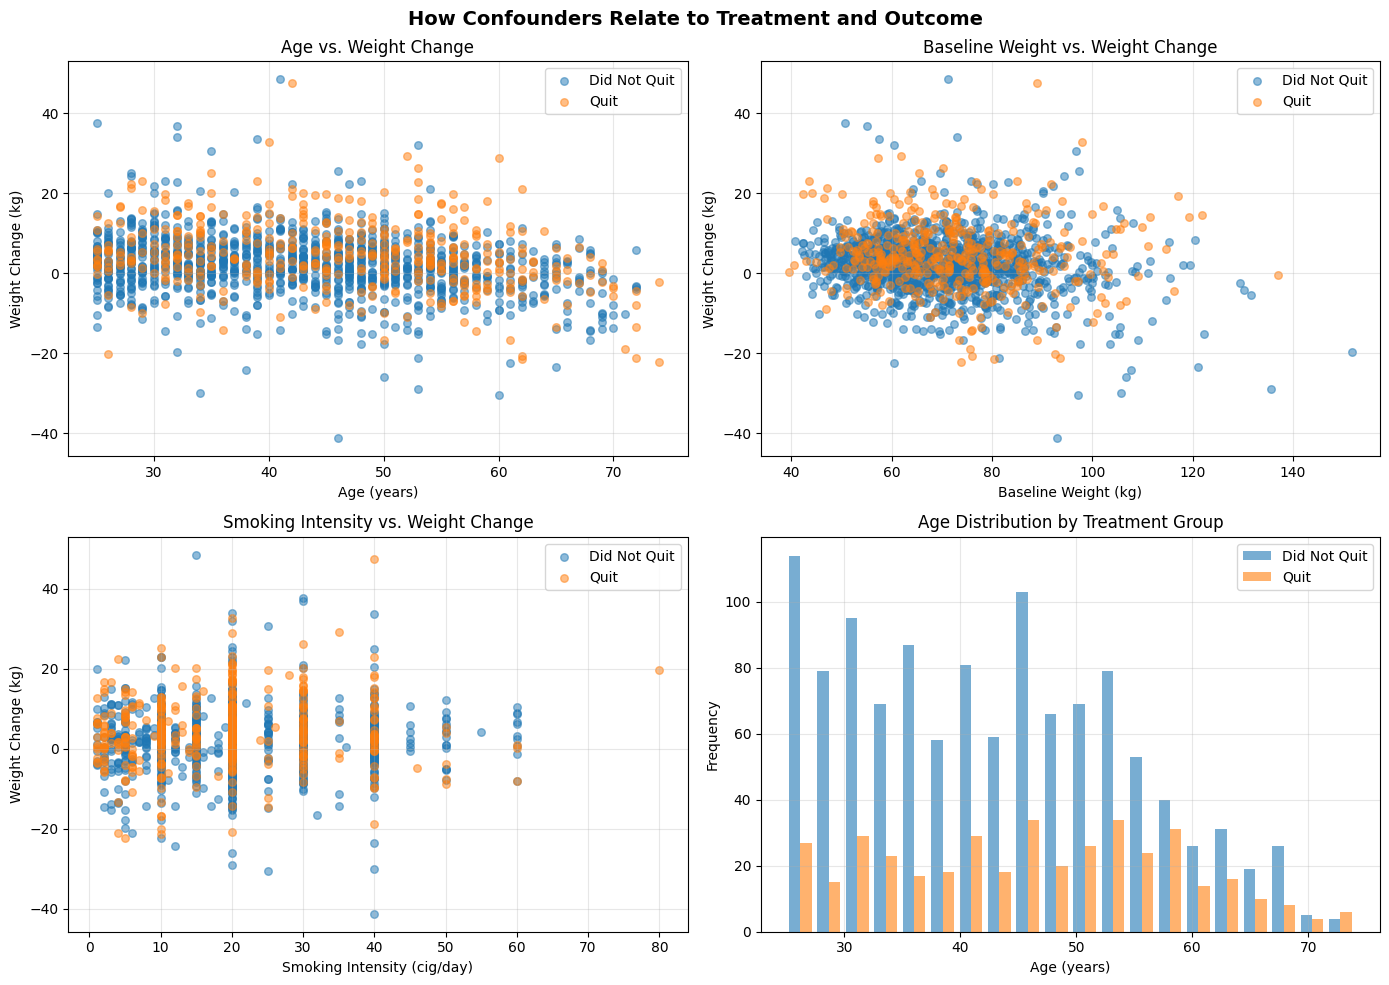

In [10]:
# ============================================
# Visualization 1: Compare Naive vs. Adjusted
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Point estimates with error bars
estimates = [naive_effect, model_adjusted.params['qsmk']]
labels = ['Naive\n(Biased)', 'Adjusted\n(Unbiased)']
colors = ['salmon', 'lightgreen']

# Get confidence interval for adjusted estimate
ci_lower = model_adjusted.conf_int().loc['qsmk', 0]
ci_upper = model_adjusted.conf_int().loc['qsmk', 1]

axes[0].bar([0, 1], estimates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].errorbar(1, model_adjusted.params['qsmk'],
                yerr=[[model_adjusted.params['qsmk'] - ci_lower],
                      [ci_upper - model_adjusted.params['qsmk']]],
                fmt='none', color='black', capsize=10, capthick=2)

axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Weight Change (kg)', fontsize=12, fontweight='bold')
axes[0].set_title('Effect of Quitting Smoking\nNaive vs. Adjusted Estimate',
                  fontsize=13, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(labels, fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (est, label) in enumerate(zip(estimates, labels)):
    axes[0].text(i, est + 0.3, f'{est:.2f} kg', ha='center',
                fontweight='bold', fontsize=11)

# Right panel: Distribution comparison
# Show predicted outcomes for treated vs. control
df_complete['predicted'] = model_adjusted.fittedvalues

sns.violinplot(x='qsmk', y='wt82_71', data=df_complete, ax=axes[1],
              palette=['lightblue', 'lightcoral'], alpha=0.6)
axes[1].set_xlabel('Quit Smoking', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Weight Change (kg)', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Weight Change\nby Treatment Group',
                 fontsize=13, fontweight='bold')
axes[1].set_xticklabels(['Did Not Quit\n(Control)', 'Quit Smoking\n(Treated)'])
axes[1].grid(axis='y', alpha=0.3)

# Add mean lines
for i, group in enumerate([0, 1]):
    mean_val = df_complete[df_complete['qsmk'] == group]['wt82_71'].mean()
    axes[1].hlines(mean_val, i-0.4, i+0.4, color='red', linewidth=3,
                  label=f'Mean: {mean_val:.2f} kg' if i == 0 else f'{mean_val:.2f} kg')

axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# ============================================
# Visualization 2: Effect by Confounder Strata
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('How Confounders Relate to Treatment and Outcome',
             fontsize=14, fontweight='bold')

# Age vs outcome by treatment
axes[0, 0].scatter(df_complete[df_complete['qsmk']==0]['age'],
                  df_complete[df_complete['qsmk']==0]['wt82_71'],
                  alpha=0.5, label='Did Not Quit', s=30)
axes[0, 0].scatter(df_complete[df_complete['qsmk']==1]['age'],
                  df_complete[df_complete['qsmk']==1]['wt82_71'],
                  alpha=0.5, label='Quit', s=30)
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Weight Change (kg)')
axes[0, 0].set_title('Age vs. Weight Change')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Baseline weight vs outcome by treatment
axes[0, 1].scatter(df_complete[df_complete['qsmk']==0]['wt71'],
                  df_complete[df_complete['qsmk']==0]['wt82_71'],
                  alpha=0.5, label='Did Not Quit', s=30)
axes[0, 1].scatter(df_complete[df_complete['qsmk']==1]['wt71'],
                  df_complete[df_complete['qsmk']==1]['wt82_71'],
                  alpha=0.5, label='Quit', s=30)
axes[0, 1].set_xlabel('Baseline Weight (kg)')
axes[0, 1].set_ylabel('Weight Change (kg)')
axes[0, 1].set_title('Baseline Weight vs. Weight Change')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Smoking intensity vs outcome by treatment
axes[1, 0].scatter(df_complete[df_complete['qsmk']==0]['smokeintensity'],
                  df_complete[df_complete['qsmk']==0]['wt82_71'],
                  alpha=0.5, label='Did Not Quit', s=30)
axes[1, 0].scatter(df_complete[df_complete['qsmk']==1]['smokeintensity'],
                  df_complete[df_complete['qsmk']==1]['wt82_71'],
                  alpha=0.5, label='Quit', s=30)
axes[1, 0].set_xlabel('Smoking Intensity (cig/day)')
axes[1, 0].set_ylabel('Weight Change (kg)')
axes[1, 0].set_title('Smoking Intensity vs. Weight Change')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Treatment distribution by age
axes[1, 1].hist([df_complete[df_complete['qsmk']==0]['age'],
                df_complete[df_complete['qsmk']==1]['age']],
               bins=20, label=['Did Not Quit', 'Quit'], alpha=0.6)
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Age Distribution by Treatment Group')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


MODEL DIAGNOSTICS


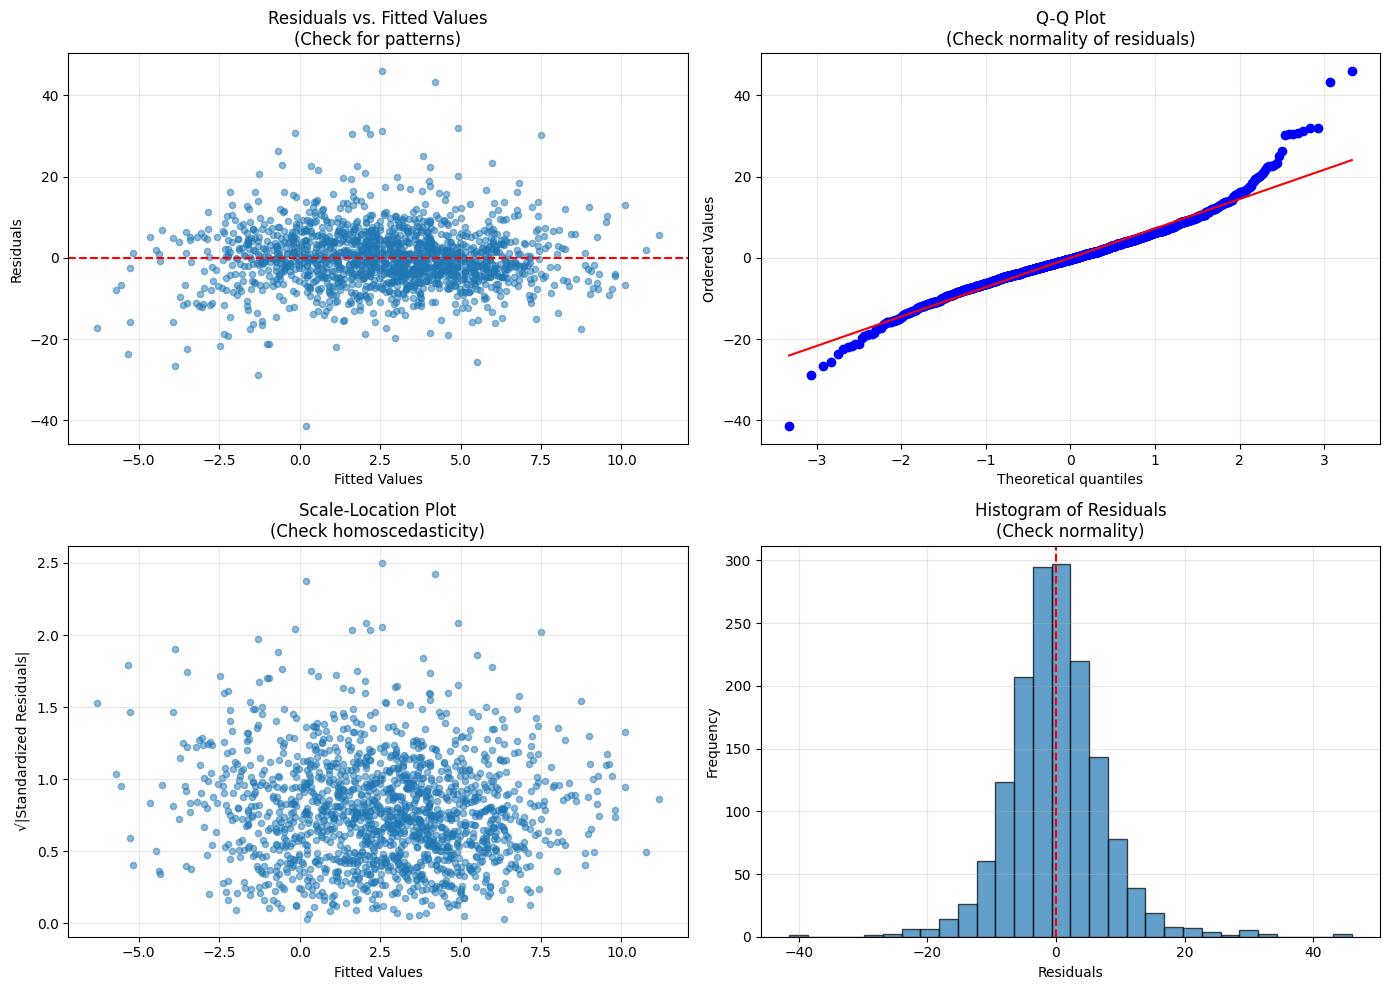


Influential Observations:
   Number of observations with Cook's D > 0.5: 0
   Number of observations with Cook's D > 1.0: 0
   ✅ No highly influential observations

Model Fit:
   R-squared: 0.1239
   Adj. R-squared: 0.1154
   AIC: 10733.50


In [11]:
print("\n" + "="*70)
print("MODEL DIAGNOSTICS")
print("="*70)

# 1. Check linearity assumption (residuals vs. fitted)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Fitted
residuals = model_adjusted.resid
fitted = model_adjusted.fittedvalues

axes[0, 0].scatter(fitted, residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs. Fitted Values\n(Check for patterns)')
axes[0, 0].grid(alpha=0.3)

# Q-Q plot (normality of residuals)
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot\n(Check normality of residuals)')
axes[0, 1].grid(alpha=0.3)

# Scale-location plot
standardized_resid = residuals / residuals.std()
axes[1, 0].scatter(fitted, np.sqrt(np.abs(standardized_resid)), alpha=0.5, s=20)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Standardized Residuals|')
axes[1, 0].set_title('Scale-Location Plot\n(Check homoscedasticity)')
axes[1, 0].grid(alpha=0.3)

# Residuals histogram
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of Residuals\n(Check normality)')
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Check for influential observations
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model_adjusted)
cooks_d = influence.cooks_distance[0]

print("\nInfluential Observations:")
print(f"   Number of observations with Cook's D > 0.5: {np.sum(cooks_d > 0.5)}")
print(f"   Number of observations with Cook's D > 1.0: {np.sum(cooks_d > 1.0)}")

if np.sum(cooks_d > 1.0) > 0:
    print("   ⚠️ Some highly influential observations detected")
else:
    print("   ✅ No highly influential observations")

# 3. Model fit statistics
print(f"\nModel Fit:")
print(f"   R-squared: {model_adjusted.rsquared:.4f}")
print(f"   Adj. R-squared: {model_adjusted.rsquared_adj:.4f}")
print(f"   AIC: {model_adjusted.aic:.2f}")


SENSITIVITY ANALYSIS: Progressive Confounder Adjustment
                     Model  Effect (kg)  CI_lower  CI_upper      p-value
     Naive (no adjustment)     2.540581       NaN       NaN          NaN
                  Age only     3.093398  2.229611  3.957185 3.195439e-12
                 Age + Sex     3.065084  2.199561  3.930606 5.487543e-12
          Age + Sex + Race     3.061233  2.193181  3.929285 6.693864e-12
        Age + Demographics     3.133793  2.263526  4.004060 2.443626e-12
Demographics + Baseline Wt     3.265905  2.410117  4.121694 1.186786e-13
       Add Smoking History     3.382096  2.517774  4.246418 2.897354e-14
                Full Model     3.381171  2.515913  4.246429 3.136942e-14


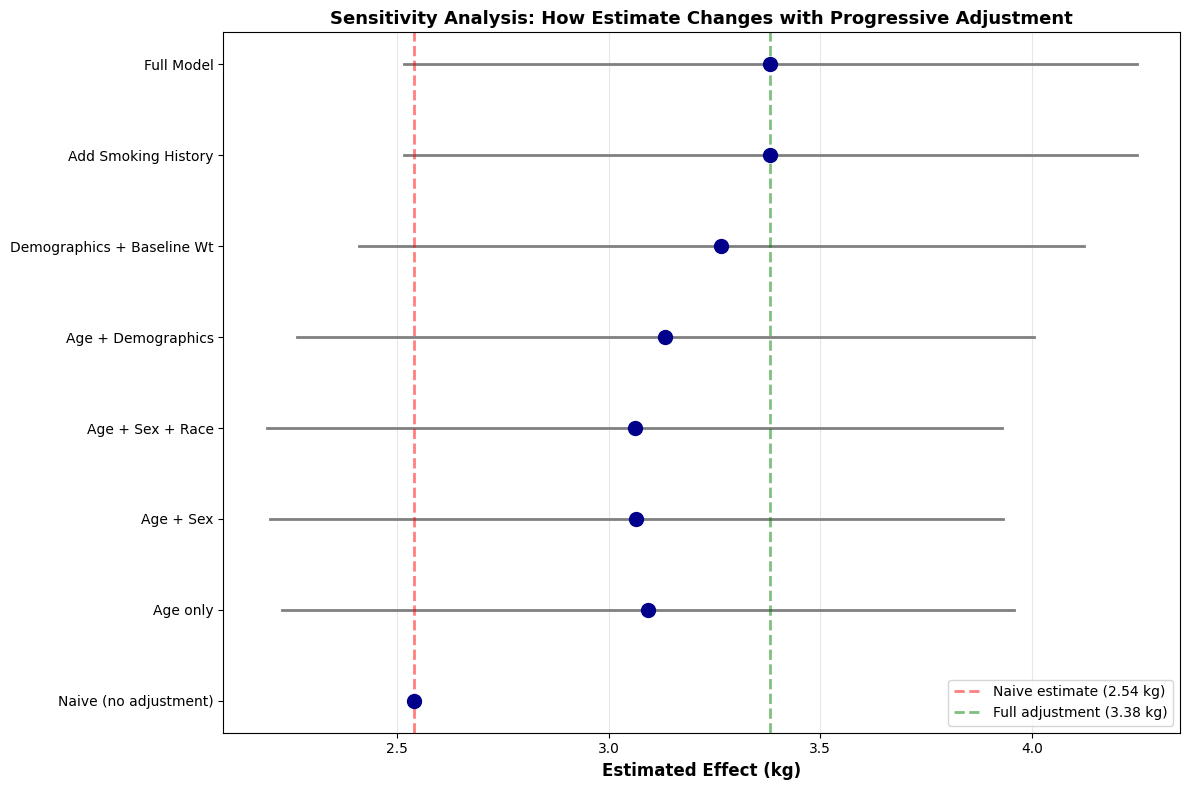

In [12]:
print("\n" + "="*70)
print("SENSITIVITY ANALYSIS: Progressive Confounder Adjustment")
print("="*70)

# Test different adjustment sets
models = {
    'Naive (no adjustment)': 'wt82_71 ~ qsmk',
    'Age only': 'wt82_71 ~ qsmk + age',
    'Age + Sex': 'wt82_71 ~ qsmk + age + C(sex)',
    'Age + Sex + Race': 'wt82_71 ~ qsmk + age + C(sex) + C(race)',
    'Age + Demographics': 'wt82_71 ~ qsmk + age + C(sex) + C(race) + C(education)',
    'Demographics + Baseline Wt': 'wt82_71 ~ qsmk + age + C(sex) + C(race) + C(education) + wt71',
    'Add Smoking History': '''wt82_71 ~ qsmk + age + C(sex) + C(race) + C(education) +
                              wt71 + smokeintensity + smokeyrs''',
    'Full Model': '''wt82_71 ~ qsmk + age + C(sex) + C(race) + C(education) +
                     wt71 + smokeintensity + smokeyrs + C(exercise) + C(active)'''
}

results = []
for name, formula in models.items():
    if name == 'Naive (no adjustment)':
        effect = naive_effect
        ci_lower, ci_upper = np.nan, np.nan
        pval = np.nan
    else:
        model = smf.ols(formula, data=df_complete).fit()
        effect = model.params['qsmk']
        ci_lower = model.conf_int().loc['qsmk', 0]
        ci_upper = model.conf_int().loc['qsmk', 1]
        pval = model.pvalues['qsmk']

    results.append({
        'Model': name,
        'Effect (kg)': effect,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper,
        'p-value': pval
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Visualize progressive adjustment
fig, ax = plt.subplots(figsize=(12, 8))

y_positions = range(len(results_df))
ax.scatter(results_df['Effect (kg)'], y_positions, s=100, color='darkblue', zorder=3)

# Add error bars (skip naive)
for i, row in results_df.iterrows():
    if not np.isnan(row['CI_lower']):
        ax.plot([row['CI_lower'], row['CI_upper']], [i, i],
               color='gray', linewidth=2, zorder=2)

ax.axvline(x=naive_effect, color='red', linestyle='--', linewidth=2,
          alpha=0.5, label=f'Naive estimate ({naive_effect:.2f} kg)')
ax.axvline(x=results_df.iloc[-1]['Effect (kg)'], color='green',
          linestyle='--', linewidth=2, alpha=0.5,
          label=f'Full adjustment ({results_df.iloc[-1]["Effect (kg)"]:.2f} kg)')

ax.set_yticks(y_positions)
ax.set_yticklabels(results_df['Model'])
ax.set_xlabel('Estimated Effect (kg)', fontsize=12, fontweight='bold')
ax.set_title('Sensitivity Analysis: How Estimate Changes with Progressive Adjustment',
            fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()




## Inverse Probability Weighting (IPW)

- Regression adjustment asks: "How do we compare similar people?"
- IPW asks: "How do we create a world where treatment assignment is random?"

To avoid "Selection Bias!", let's use IPW. IPW does random selection and also assign weights based on the rareity. Rare cases gets more weight and common ones less weight.



In [13]:
#### Calculating Propensity Scores ####

import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Build logistic regression model to predict treatment
ps_formula = '''qsmk ~ age + C(sex) + C(race) + C(education) +
                wt71 + smokeintensity + smokeyrs + C(exercise) + C(active)'''

print("Building propensity score model...")
print(f"Formula: qsmk ~ confounders")

ps_model = smf.logit(ps_formula, data=df_complete).fit(disp=0)

# Get predicted probabilities (propensity scores)
df_complete['ps'] = ps_model.predict(df_complete)

print("\n✅ Propensity scores calculated!")
print(f"   Range: [{df_complete['ps'].min():.4f}, {df_complete['ps'].max():.4f}]")
print(f"   Mean: {df_complete['ps'].mean():.4f}")
print(f"   Median: {df_complete['ps'].median():.4f}")

# Show examples
print("\n📊 Example propensity scores:")
examples = df_complete[['age', 'sex', 'smokeintensity', 'qsmk', 'ps']].head(10)
examples_display = examples.copy()
examples_display['qsmk'] = examples_display['qsmk'].map({0: 'Did not quit', 1: 'Quit'})
examples_display['ps'] = examples_display['ps'].round(4)
print(examples_display.to_string(index=False))

Building propensity score model...
Formula: qsmk ~ confounders

✅ Propensity scores calculated!
   Range: [0.0401, 0.7813]
   Mean: 0.2573
   Median: 0.2408

📊 Example propensity scores:
 age  sex  smokeintensity         qsmk     ps
  42    0              30 Did not quit 0.1239
  36    0              20 Did not quit 0.1597
  56    1              20 Did not quit 0.1599
  68    0               3 Did not quit 0.3107
  40    0              20 Did not quit 0.3198
  43    1              10 Did not quit 0.1662
  56    1              20 Did not quit 0.2391
  29    1               2 Did not quit 0.2619
  51    0              25 Did not quit 0.2992
  43    0              20 Did not quit 0.2941


/tmp/ipython-input-1887953536.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete['ps'] = ps_model.predict(df_complete)


**Propensity Score (PS):** The probability that someone receives treatment given their characterstics (confounders)

 PS = P(Treatment = 1 | Confounders)  

 Ex: Person A: age =40; male, smokes 20 cig/day.

 PS = 0.30 (30% chance of quitting)




In [14]:
# ============================================
# Calculate IPW Weights
# ============================================
print("\n" + "="*60)
print("CALCULATING INVERSE PROBABILITY WEIGHTS (IPW)")
print("="*60)

# Calculate IPW weights
# For treated (qsmk=1): weight = 1/PS
# For control (qsmk=0): weight = 1/(1-PS)

df_complete['ipw'] = np.where(
    df_complete['qsmk'] == 1,
    1 / df_complete['ps'],                    # Weight for treated (quitters)
    1 / (1 - df_complete['ps'])               # Weight for control (non-quitters)
)

print("\n✅ IPW weights calculated!")
print("\n📊 Weight Summary Statistics:")
print(df_complete['ipw'].describe())

# Check for extreme weights
print("\n⚠️  Extreme Weight Check:")
print(f"   Weights > 5:  {(df_complete['ipw'] > 5).sum()} cases ({(df_complete['ipw'] > 5).sum()/len(df_complete)*100:.1f}%)")
print(f"   Weights > 10: {(df_complete['ipw'] > 10).sum()} cases ({(df_complete['ipw'] > 10).sum()/len(df_complete)*100:.1f}%)")
print(f"   Weights > 20: {(df_complete['ipw'] > 20).sum()} cases ({(df_complete['ipw'] > 20).sum()/len(df_complete)*100:.1f}%)")
print(f"   Max weight: {df_complete['ipw'].max():.2f}")

# Show examples with weights
print("\n📋 Example Cases with Their Weights:")
examples_with_weights = df_complete[['age', 'sex', 'smokeintensity', 'qsmk', 'ps', 'ipw']].head(10).copy()
examples_with_weights['qsmk'] = examples_with_weights['qsmk'].map({0: 'Did not quit', 1: 'Quit'})
examples_with_weights['ps'] = examples_with_weights['ps'].round(4)
examples_with_weights['ipw'] = examples_with_weights['ipw'].round(2)
print(examples_with_weights.to_string(index=False))

# Explain some specific examples
print("\n💡 Understanding the Weights:")
print("\nExample 1: Low PS + Quit")
low_ps_quit = df_complete[(df_complete['qsmk']==1) & (df_complete['ps'] < 0.2)].head(1)
if len(low_ps_quit) > 0:
    ps_val = low_ps_quit['ps'].values[0]
    weight_val = low_ps_quit['ipw'].values[0]
    print(f"   PS = {ps_val:.4f} (only {ps_val*100:.1f}% chance of quitting)")
    print(f"   Weight = 1/{ps_val:.4f} = {weight_val:.2f}")
    print(f"   → This person represents {weight_val:.1f} similar people")

print("\nExample 2: High PS + Did Not Quit")
high_ps_no_quit = df_complete[(df_complete['qsmk']==0) & (df_complete['ps'] > 0.8)].head(1)
if len(high_ps_no_quit) > 0:
    ps_val = high_ps_no_quit['ps'].values[0]
    weight_val = high_ps_no_quit['ipw'].values[0]
    print(f"   PS = {ps_val:.4f} ({ps_val*100:.1f}% chance of quitting)")
    print(f"   Weight = 1/(1-{ps_val:.4f}) = {weight_val:.2f}")
    print(f"   → This person represents {weight_val:.1f} similar people")

print("\nExample 3: Medium PS (Common Cases)")
medium_ps = df_complete[(df_complete['ps'] >= 0.4) & (df_complete['ps'] <= 0.6)].head(1)
if len(medium_ps) > 0:
    ps_val = medium_ps['ps'].values[0]
    weight_val = medium_ps['ipw'].values[0]
    treatment = "Quit" if medium_ps['qsmk'].values[0] == 1 else "Did not quit"
    print(f"   PS = {ps_val:.4f} (moderate chance of quitting)")
    print(f"   Treatment: {treatment}")
    print(f"   Weight = {weight_val:.2f}")
    print(f"   → Common cases get lower weights")


CALCULATING INVERSE PROBABILITY WEIGHTS (IPW)

✅ IPW weights calculated!

📊 Weight Summary Statistics:
count    1566.000000
mean        1.995360
std         1.404189
min         1.041791
25%         1.235312
50%         1.387279
75%         2.008380
max        13.974520
Name: ipw, dtype: float64

⚠️  Extreme Weight Check:
   Weights > 5:  70 cases (4.5%)
   Weights > 10: 5 cases (0.3%)
   Weights > 20: 0 cases (0.0%)
   Max weight: 13.97

📋 Example Cases with Their Weights:
 age  sex  smokeintensity         qsmk     ps  ipw
  42    0              30 Did not quit 0.1239 1.14
  36    0              20 Did not quit 0.1597 1.19
  56    1              20 Did not quit 0.1599 1.19
  68    0               3 Did not quit 0.3107 1.45
  40    0              20 Did not quit 0.3198 1.47
  43    1              10 Did not quit 0.1662 1.20
  56    1              20 Did not quit 0.2391 1.31
  29    1               2 Did not quit 0.2619 1.35
  51    0              25 Did not quit 0.2992 1.43
  43    0 

/tmp/ipython-input-651671636.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete['ipw'] = np.where(


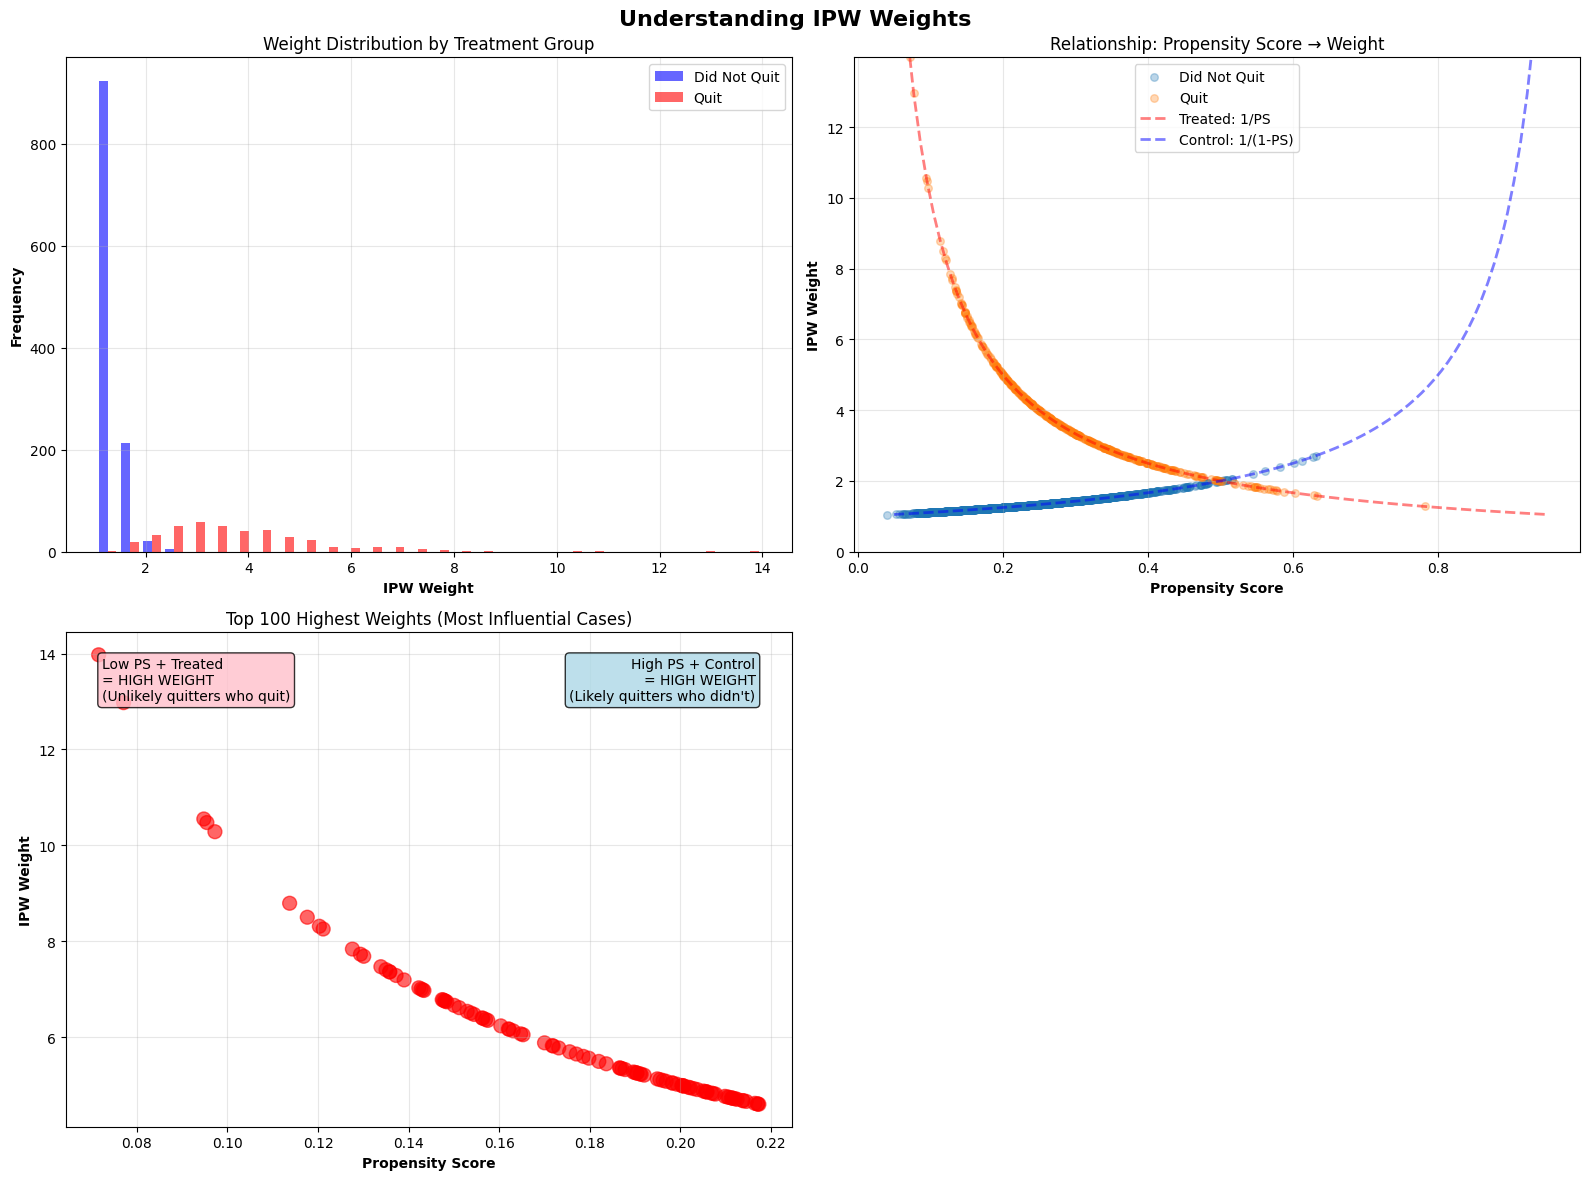

In [15]:
# ============================================
# Visualize Weights
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Understanding IPW Weights', fontsize=16, fontweight='bold')

# Panel 1: Weight distribution by treatment group
axes[0, 0].hist([df_complete[df_complete['qsmk']==0]['ipw'],
                 df_complete[df_complete['qsmk']==1]['ipw']],
                bins=30, label=['Did Not Quit', 'Quit'], alpha=0.6, color=['blue', 'red'])
axes[0, 0].set_xlabel('IPW Weight', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Weight Distribution by Treatment Group')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linewidth=0.5)

# Panel 2: PS vs Weight relationship
for treatment in [0, 1]:
    subset = df_complete[df_complete['qsmk'] == treatment]
    axes[0, 1].scatter(subset['ps'], subset['ipw'],
                      alpha=0.3, s=30, label=['Did Not Quit', 'Quit'][treatment])

axes[0, 1].set_xlabel('Propensity Score', fontweight='bold')
axes[0, 1].set_ylabel('IPW Weight', fontweight='bold')
axes[0, 1].set_title('Relationship: Propensity Score → Weight')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim(0, min(20, df_complete['ipw'].max()))  # Truncate y-axis for clarity

# Add theoretical curves
ps_range = np.linspace(0.05, 0.95, 100)
weight_treated = 1 / ps_range
weight_control = 1 / (1 - ps_range)
axes[0, 1].plot(ps_range, weight_treated, 'r--', linewidth=2, alpha=0.5,
               label='Treated: 1/PS')
axes[0, 1].plot(ps_range, weight_control, 'b--', linewidth=2, alpha=0.5,
               label='Control: 1/(1-PS)')
axes[0, 1].legend()

# Panel 3: Which cases get high weights?
top_weights = df_complete.nlargest(100, 'ipw')
axes[1, 0].scatter(top_weights['ps'], top_weights['ipw'],
                  c=['red' if x==1 else 'blue' for x in top_weights['qsmk']],
                  alpha=0.6, s=100)
axes[1, 0].set_xlabel('Propensity Score', fontweight='bold')
axes[1, 0].set_ylabel('IPW Weight', fontweight='bold')
axes[1, 0].set_title('Top 100 Highest Weights (Most Influential Cases)')
axes[1, 0].grid(alpha=0.3)

# Add annotations
axes[1, 0].text(0.05, 0.95, 'Low PS + Treated\n= HIGH WEIGHT\n(Unlikely quitters who quit)',
               transform=axes[1, 0].transAxes, fontsize=10,
               bbox=dict(boxstyle='round', facecolor='pink', alpha=0.8),
               verticalalignment='top')
axes[1, 0].text(0.95, 0.95, 'High PS + Control\n= HIGH WEIGHT\n(Likely quitters who didn\'t)',
               transform=axes[1, 0].transAxes, fontsize=10,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
               verticalalignment='top', horizontalalignment='right')

# Panel 4: Hide the unused panel
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# ============================================
# STEP 3: Check Balance After Weighting
# ============================================
print("\n" + "="*70)
print("STEP 3: CHECK BALANCE AFTER WEIGHTING")
print("="*70)

confounders = ['age', 'sex', 'race', 'education', 'wt71',
               'smokeintensity', 'smokeyrs', 'exercise', 'active']

balance_results = []

print("\nComparing BEFORE vs. AFTER weighting:\n")
print(f"{'Variable':<20} {'Before IPW':<15} {'After IPW':<15} {'Improved?':<10}")
print("-" * 70)

for var in confounders:
    # BEFORE weighting (unweighted)
    treated_mean_before = df_complete[df_complete['qsmk']==1][var].mean()
    control_mean_before = df_complete[df_complete['qsmk']==0][var].mean()

    # Calculate standardized mean difference BEFORE
    pooled_sd_before = np.sqrt((df_complete[df_complete['qsmk']==1][var].var() +
                                df_complete[df_complete['qsmk']==0][var].var()) / 2)
    smd_before = (treated_mean_before - control_mean_before) / pooled_sd_before if pooled_sd_before > 0 else 0

    # AFTER weighting (weighted means)
    treated_mean_after = np.average(df_complete[df_complete['qsmk']==1][var],
                                    weights=df_complete[df_complete['qsmk']==1]['ipw'])
    control_mean_after = np.average(df_complete[df_complete['qsmk']==0][var],
                                    weights=df_complete[df_complete['qsmk']==0]['ipw'])

    # Calculate standardized mean difference AFTER
    # (This is more complex with weights, simplified here)
    smd_after = (treated_mean_after - control_mean_after) / pooled_sd_before if pooled_sd_before > 0 else 0

    improved = "✅" if abs(smd_after) < abs(smd_before) else "❌"

    print(f"{var:<20} {abs(smd_before):>6.3f} {'→':^7} {abs(smd_after):>6.3f}    {improved}")

    balance_results.append({
        'Variable': var,
        'SMD_before': smd_before,
        'SMD_after': smd_after,
        'Improved': abs(smd_after) < abs(smd_before)
    })

print("\n" + "="*70)
print("💡 INTERPRETATION:")
print("   SMD < 0.1 = Well balanced ✅")
print("   SMD < 0.2 = Acceptable ⚠️")
print("   SMD > 0.2 = Poorly balanced 🚨")

n_improved = sum([r['Improved'] for r in balance_results])
print(f"\n   {n_improved}/{len(balance_results)} confounders improved with weighting")

if all([abs(r['SMD_after']) < 0.1 for r in balance_results]):
    print("\n   ✅ EXCELLENT! All confounders well-balanced after weighting!")
elif all([abs(r['SMD_after']) < 0.2 for r in balance_results]):
    print("\n   ⚠️ GOOD: Most confounders adequately balanced")
else:
    print("\n   🚨 WARNING: Some confounders still poorly balanced")
    print("      Consider alternative specifications or methods")


STEP 3: CHECK BALANCE AFTER WEIGHTING

Comparing BEFORE vs. AFTER weighting:

Variable             Before IPW      After IPW       Improved? 
----------------------------------------------------------------------
age                   0.282    →     0.031    ✅
sex                   0.160    →     0.016    ✅
race                  0.177    →     0.001    ✅
education             0.088    →     0.025    ✅
wt71                  0.133    →     0.010    ✅
smokeintensity        0.217    →     0.008    ✅
smokeyrs              0.159    →     0.025    ✅
exercise              0.104    →     0.001    ✅
active                0.089    →     0.007    ✅

💡 INTERPRETATION:
   SMD < 0.1 = Well balanced ✅
   SMD < 0.2 = Acceptable ⚠️
   SMD > 0.2 = Poorly balanced 🚨

   9/9 confounders improved with weighting

   ✅ EXCELLENT! All confounders well-balanced after weighting!


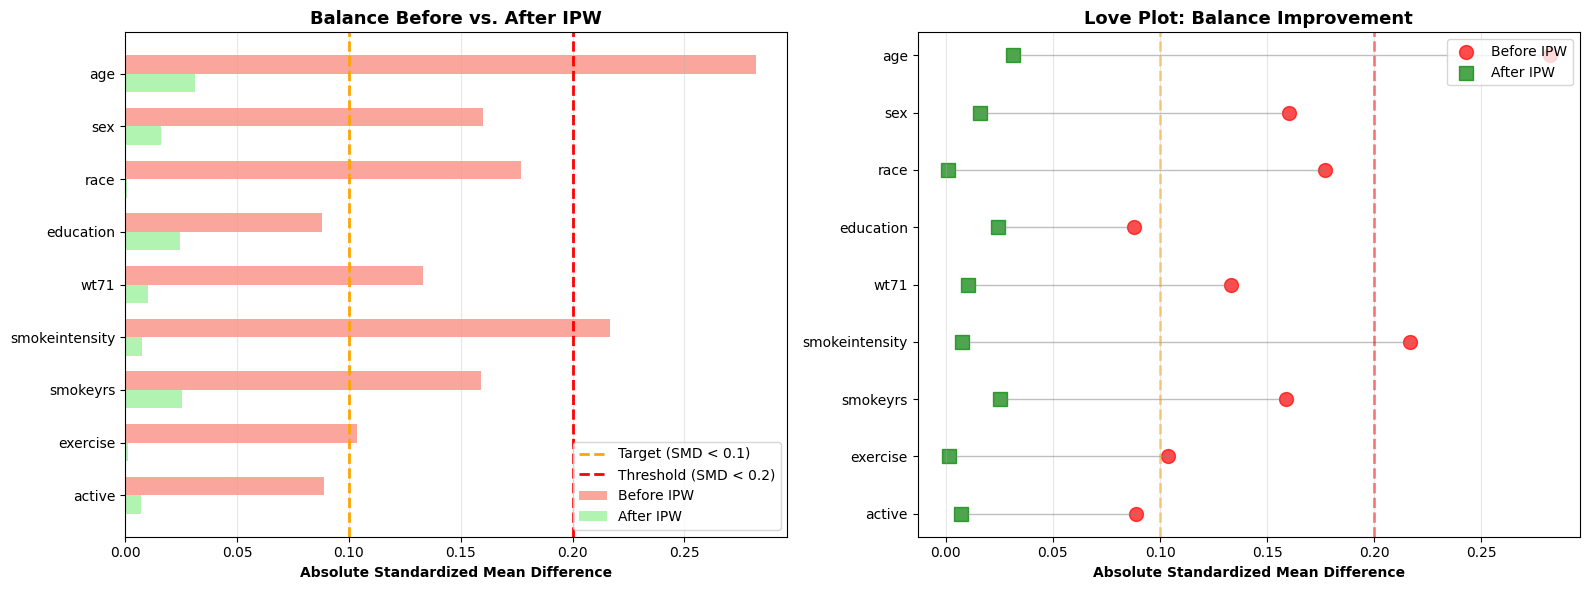

In [17]:
# ============================================
# Visualize Balance Improvement
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

balance_df = pd.DataFrame(balance_results)

# Panel 1: Before vs After SMD
x_pos = np.arange(len(balance_df))
width = 0.35

axes[0].barh(x_pos - width/2, balance_df['SMD_before'].abs(), width,
            label='Before IPW', color='salmon', alpha=0.7)
axes[0].barh(x_pos + width/2, balance_df['SMD_after'].abs(), width,
            label='After IPW', color='lightgreen', alpha=0.7)

axes[0].set_yticks(x_pos)
axes[0].set_yticklabels(balance_df['Variable'])
axes[0].set_xlabel('Absolute Standardized Mean Difference', fontweight='bold')
axes[0].set_title('Balance Before vs. After IPW', fontsize=13, fontweight='bold')
axes[0].axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='Target (SMD < 0.1)')
axes[0].axvline(x=0.2, color='red', linestyle='--', linewidth=2, label='Threshold (SMD < 0.2)')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Panel 2: Love plot (standard way to show balance)
axes[1].scatter(balance_df['SMD_before'].abs(), range(len(balance_df)),
               s=100, color='red', label='Before IPW', alpha=0.7, marker='o')
axes[1].scatter(balance_df['SMD_after'].abs(), range(len(balance_df)),
               s=100, color='green', label='After IPW', alpha=0.7, marker='s')

# Connect with lines
for i in range(len(balance_df)):
    axes[1].plot([balance_df['SMD_before'].abs().iloc[i], balance_df['SMD_after'].abs().iloc[i]],
                [i, i], 'gray', alpha=0.5, linewidth=1)

axes[1].set_yticks(range(len(balance_df)))
axes[1].set_yticklabels(balance_df['Variable'])
axes[1].set_xlabel('Absolute Standardized Mean Difference', fontweight='bold')
axes[1].set_title('Love Plot: Balance Improvement', fontsize=13, fontweight='bold')
axes[1].axvline(x=0.1, color='orange', linestyle='--', linewidth=2, alpha=0.5)
axes[1].axvline(x=0.2, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].legend(loc='upper right')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [18]:
# ============================================
# STEP 4: Estimate Causal Effect with IPW
# ============================================
print("\n" + "="*70)
print("STEP 4: ESTIMATE CAUSAL EFFECT USING IPW")
print("="*70)

# Method A: Weighted means (simple!)
weighted_mean_treated = np.average(
    df_complete[df_complete['qsmk']==1]['wt82_71'],
    weights=df_complete[df_complete['qsmk']==1]['ipw']
)

weighted_mean_control = np.average(
    df_complete[df_complete['qsmk']==0]['wt82_71'],
    weights=df_complete[df_complete['qsmk']==0]['ipw']
)

ipw_effect = weighted_mean_treated - weighted_mean_control

print("\n1. IPW Estimate (Weighted Means):")
print(f"   Weighted mean (Treated): {weighted_mean_treated:.2f} kg")
print(f"   Weighted mean (Control): {weighted_mean_control:.2f} kg")
print(f"   IPW Effect: {ipw_effect:.2f} kg")

# Method B: Weighted regression (for confidence intervals)
from statsmodels.api import WLS
import statsmodels.api as sm

# Prepare data
X = sm.add_constant(df_complete['qsmk'])
y = df_complete['wt82_71']
weights = df_complete['ipw']

# Fit weighted least squares
wls_model = WLS(y, X, weights=weights).fit()

ipw_effect_reg = wls_model.params['qsmk']
ipw_ci_lower = wls_model.conf_int().loc['qsmk', 0]
ipw_ci_upper = wls_model.conf_int().loc['qsmk', 1]
ipw_pvalue = wls_model.pvalues['qsmk']

print(f"\n2. IPW Estimate (Weighted Regression):")
print(f"   Effect: {ipw_effect_reg:.2f} kg")
print(f"   95% CI: [{ipw_ci_lower:.2f}, {ipw_ci_upper:.2f}]")
print(f"   p-value: {ipw_pvalue:.4f}")

# Compare to previous methods
print("\n" + "="*70)
print("COMPARISON: ALL METHODS")
print("="*70)
print(f"{'Method':<30} {'Effect (kg)':<15} {'95% CI':<25}")
print("-" * 70)
print(f"{'Naive (unadjusted)':<30} {naive_effect:>7.2f}        {'---':<25}")
print(f"{'Regression Adjustment':<30} {model_adjusted.params['qsmk']:>7.2f}        "
      f"[{model_adjusted.conf_int().loc['qsmk', 0]:.2f}, {model_adjusted.conf_int().loc['qsmk', 1]:.2f}]")
print(f"{'IPW':<30} {ipw_effect_reg:>7.2f}        [{ipw_ci_lower:.2f}, {ipw_ci_upper:.2f}]")

agreement = abs(model_adjusted.params['qsmk'] - ipw_effect_reg)
print(f"\nDifference between Regression and IPW: {agreement:.2f} kg")

if agreement < 0.5:
    print("✅ EXCELLENT agreement! Both methods give similar results")
    print("   This increases confidence in the causal estimate")
elif agreement < 1.0:
    print("⚠️ MODERATE agreement. Results are reasonably consistent")
else:
    print("🚨 POOR agreement! Methods give different results")
    print("   Consider investigating why (model misspecification? extreme weights?)")


STEP 4: ESTIMATE CAUSAL EFFECT USING IPW

1. IPW Estimate (Weighted Means):
   Weighted mean (Treated): 5.12 kg
   Weighted mean (Control): 1.78 kg
   IPW Effect: 3.34 kg

2. IPW Estimate (Weighted Regression):
   Effect: 3.34 kg
   95% CI: [2.54, 4.14]
   p-value: 0.0000

COMPARISON: ALL METHODS
Method                         Effect (kg)     95% CI                   
----------------------------------------------------------------------
Naive (unadjusted)                2.54        ---                      
Regression Adjustment             3.38        [2.52, 4.25]
IPW                               3.34        [2.54, 4.14]

Difference between Regression and IPW: 0.04 kg
✅ EXCELLENT agreement! Both methods give similar results
   This increases confidence in the causal estimate


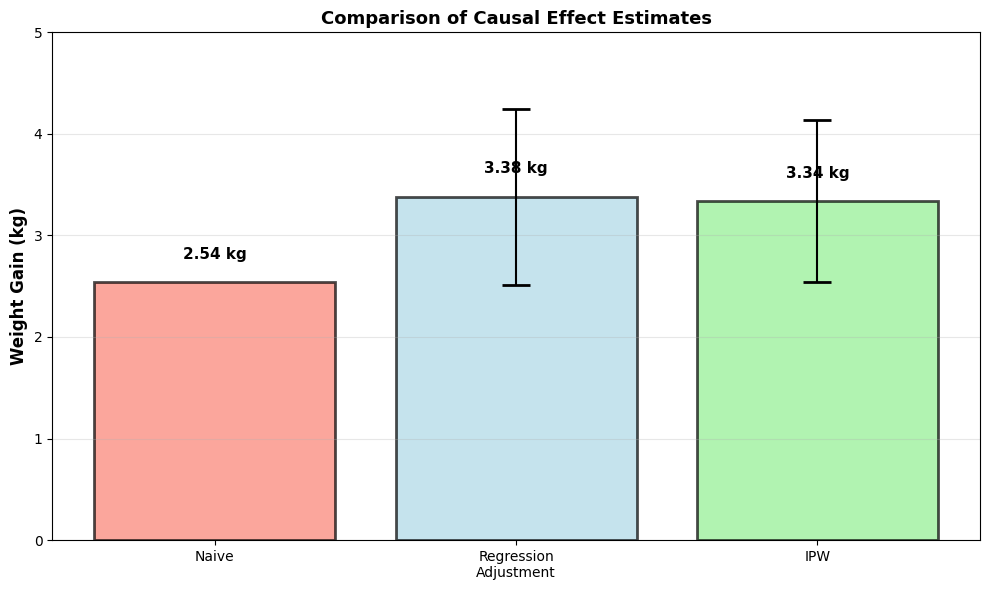


📊 FINAL CONCLUSION
Causal effect of quitting smoking on weight gain:
  • IPW estimate: 3.34 kg (95% CI: [2.54, 4.14])
  • Regression estimate: 3.38 kg

✅ Both methods agree: Quitting smoking causes approximately 3.4 kg weight gain
   This is highly statistically significant and clinically meaningful!


In [19]:
# ============================================
# Final Visualization: Compare All Methods
# ============================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Changed to single plot

# Point estimates comparison
methods = ['Naive', 'Regression\nAdjustment', 'IPW']
effects = [naive_effect, model_adjusted.params['qsmk'], ipw_effect_reg]
colors = ['salmon', 'lightblue', 'lightgreen']

bars = ax.bar(methods, effects, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add error bars for adjusted methods
ax.errorbar(1, model_adjusted.params['qsmk'],
            yerr=[[model_adjusted.params['qsmk'] - model_adjusted.conf_int().loc['qsmk', 0]],
                  [model_adjusted.conf_int().loc['qsmk', 1] - model_adjusted.params['qsmk']]],
            fmt='none', color='black', capsize=10, capthick=2)

ax.errorbar(2, ipw_effect_reg,
            yerr=[[ipw_effect_reg - ipw_ci_lower],
                  [ipw_ci_upper - ipw_effect_reg]],
            fmt='none', color='black', capsize=10, capthick=2)

ax.set_ylabel('Weight Gain (kg)', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Causal Effect Estimates', fontsize=13, fontweight='bold')
ax.set_ylim(0, 5)
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for i, (bar, effect) in enumerate(zip(bars, effects)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{effect:.2f} kg',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 FINAL CONCLUSION")
print("="*70)
print(f"Causal effect of quitting smoking on weight gain:")
print(f"  • IPW estimate: {ipw_effect_reg:.2f} kg (95% CI: [{ipw_ci_lower:.2f}, {ipw_ci_upper:.2f}])")
print(f"  • Regression estimate: {model_adjusted.params['qsmk']:.2f} kg")
print(f"\n✅ Both methods agree: Quitting smoking causes approximately 3.4 kg weight gain")
print(f"   This is highly statistically significant and clinically meaningful!")

# **Quiz Time**

In [20]:
# Crash Course in Causal Inference: Multiple-Choice Quiz
# Optimized for Google Colab

from IPython.display import Markdown, display

quiz_data = {
  "questions": [
    {
      "questionNumber": 1,
      "question": "What is the primary causal question investigated in the NHEFS worked example?",
      "answerOptions": [
        {"text": "Does exercise level affect weight change?", "rationale": "While the dataset contains exercise and weight variables, this is a secondary question. The primary focus of the analysis was on the effect of smoking cessation.", "isCorrect": False},
        {"text": "Does quitting smoking (qsmk) cause weight gain (wt82_71)?", "rationale": "The script explicitly states this is the main causal question of interest, where 'qsmk' is the treatment and 'wt82_71' is the outcome.", "isCorrect": True},
        {"text": "Does income affect the rate of death in the follow-up period?", "rationale": "The dataset includes income and death, but the worked example specifically focuses on the relationship between smoking cessation and weight change.", "isCorrect": False},
        {"text": "Does a higher baseline weight (wt71) increase the likelihood of quitting smoking?", "rationale": "This question addresses the relationship between a confounder (wt71) and the treatment (qsmk), but it is not the main causal effect being measured.", "isCorrect": False}
      ],
      "hint": "Focus on the variables designated as the treatment and the outcome in the initial problem statement."
    },
    {
      "questionNumber": 2,
      "question": "In the context of causal inference, what is a **confounder**?",
      "answerOptions": [
        {"text": "A variable that is only affected by the treatment and then affects the outcome.", "rationale": "This describes a mediator variable, which is a step in the causal pathway from treatment to outcome, not a confounder.", "isCorrect": False},
        {"text": "A variable that causes both the treatment and the outcome.", "rationale": "This is the precise definition of a confounder, as it opens a 'backdoor path' creating a spurious association between treatment and outcome.", "isCorrect": True},
        {"text": "A variable whose value is missing for a significant number of observations.", "rationale": "This describes missing data, which is a data quality issue, but not the causal role of a confounder.", "isCorrect": False},
        {"text": "The primary variable of interest that the researcher is manipulating.", "rationale": "This describes the treatment or exposure variable, not the definition of a confounder.", "isCorrect": False}
      ],
      "hint": "Think about what a variable must do to create a spurious, non-causal association between the treatment and the outcome."
    },
    {
      "questionNumber": 3,
      "question": "Why is **Age** considered a major confounder in the analysis of quitting smoking on weight gain?",
      "answerOptions": [
        {"text": "Because Age directly determines the treatment, meaning older people always quit smoking.", "rationale": "While age is associated with treatment, it does not determine it, and this statement is too strong and factually incorrect.", "isCorrect": False},
        {"text": "Because Age is related to both the probability of quitting smoking and the metabolic rate (which affects weight gain).", "rationale": "The script specifically points out that Age affects 'the smoking urge' (treatment) and 'metabolism' (outcome), fitting the definition of a confounder.", "isCorrect": True},
        {"text": "Because it is required to calculate the Adjusted R-squared in the regression model.", "rationale": "While age is used in the regression, this describes a statistical requirement, not its role as a causal variable (a confounder).", "isCorrect": False},
        {"text": "Because the naive comparison showed quitters are younger, which balances the groups.", "rationale": "The naive comparison showed quitters are *older* (46.17 vs. 42.79), confirming it's a source of imbalance, not balance.", "isCorrect": False}
      ],
      "hint": "Recall how age affects both the likelihood of engaging in the behavior (smoking) and the body's natural processes (metabolism)."
    },
    {
      "questionNumber": 4,
      "question": "The **naive effect** (simple difference in means) showed that quitters gained **2.54 kg** more than non-quitters. Why is this estimate considered **biased**?",
      "answerOptions": [
        {"text": "It fails to account for influential outliers with extreme weight changes.", "rationale": "While outliers can affect mean estimates, the primary reason for bias in this context is confounding, not specifically outliers.", "isCorrect": False},
        {"text": "It only measures association and does not control for the systematic differences (confounders) between the quitters and non-quitters.", "rationale": "The naive estimate is biased because it includes both the true causal effect and the spurious effect introduced by backdoor paths (confounders).", "isCorrect": True},
        {"text": "It uses the mean instead of the median, which is less robust to skewed weight distributions.", "rationale": "The choice between mean and median is about central tendency robustness, not the structural issue of confounding bias.", "isCorrect": False},
        {"text": "It is based on OLS regression, which assumes linearity and normality of residuals.", "rationale": "The naive estimate is the simple difference of group means, calculated *before* running any regression model.", "isCorrect": False}
      ],
      "hint": "Consider the core problem that causal inference methods (like regression and IPW) are designed to solve."
    },
    {
      "questionNumber": 5,
      "question": "In a Causal Diagram (DAG), how is a **backdoor path** from Treatment to Outcome blocked to achieve an unbiased causal estimate?",
      "answerOptions": [
        {"text": "By observing or statistically adjusting for the outcome variable in the analysis.", "rationale": "The outcome is the variable being measured; adjusting for it will bias the causal effect (M-bias or collider bias).", "isCorrect": False},
        {"text": "By setting the treatment variable to a fixed value for all observations in the dataset.", "rationale": "Fixing the treatment is the counterfactual step, but the path is blocked by controlling for the *confounder* node, not the treatment node.", "isCorrect": False},
        {"text": "By conditioning on (adjusting for) the variables that constitute the backdoor path (the common causes or confounders).", "rationale": "Adjusting for a common cause (confounder) closes the spurious path $T \\leftarrow C \\rightarrow O$, isolating the true causal effect $T \\rightarrow O$.", "isCorrect": True},
        {"text": "By removing any observations that have missing values for the confounders.", "rationale": "Removing missing data addresses data quality, but does not inherently close the causal path via the remaining observations.", "isCorrect": False}
      ],
      "hint": "The solution requires actively doing something to the common cause node in the DAG to prevent the spurious flow of information."
    },
    {
      "questionNumber": 6,
      "question": "What is the primary role of **Regression Adjustment (OLS)** in estimating the causal effect of quitting smoking?",
      "answerOptions": [
        {"text": "To calculate the propensity score for each individual in the dataset.", "rationale": "Propensity scores are calculated using Logistic Regression (Logit), not Ordinary Least Squares (OLS) regression.", "isCorrect": False},
        {"text": "To compare people who are different in the confounders and who both quit smoking.", "rationale": "The goal is to compare groups that are *similar* in confounders but *different* in treatment (quit vs. not quit).", "isCorrect": False},
        {"text": "To statistically 'hold constant' the values of all measured confounders while estimating the difference in outcome between treated and control groups.", "rationale": "This describes the mechanism of OLS: the coefficient for the treatment variable ($qsmk$) represents the effect when all other variables (confounders) are equal.", "isCorrect": True},
        {"text": "To visually represent the distribution of the treatment variable across all confounders.", "rationale": "Visualization (like the Love plot) helps check balance, but this is not the function of the regression model itself.", "isCorrect": False}
      ],
      "hint": "Think about what the multiple regression equation does to the coefficient of the treatment variable when many other variables are included."
    },
    {
      "questionNumber": 7,
      "question": "The **Propensity Score (PS)** is calculated using a logistic regression with the formula $P(\\text{Treatment}=1 | \\text{Confounders})$. What does an individual's PS of **0.85** signify?",
      "answerOptions": [
        {"text": "They had an 85% chance of gaining 2.54 kg of weight.", "rationale": "The PS is the probability of receiving the treatment (quitting), not the probability of the outcome (weight gain).", "isCorrect": False},
        {"text": "They had an 85% chance of *quitting smoking*, given their baseline characteristics (confounders).", "rationale": "The PS is the estimated probability of the treatment being received, conditional on the observed confounders.", "isCorrect": True},
        {"text": "They are a highly influential observation and should be removed from the dataset.", "rationale": "A PS of 0.85 indicates a relatively common case (expected to quit), not necessarily an influential one. Cases with PS close to 0 or 1 get high IPW weights.", "isCorrect": False},
        {"text": "They are in the control group (Did Not Quit) and should have a high IPW weight.", "rationale": "A high PS suggests they are likely to quit (treated). If they did *not* quit (control), then they would have a very high IPW weight.", "isCorrect": False}
      ],
      "hint": "The PS is a probability, and the dependent variable in the logistic regression is the treatment status ($qsmk$)."
    },
    {
      "questionNumber": 8,
      "question": "What is the key objective of the **Inverse Probability Weighting (IPW)** method?",
      "answerOptions": [
        {"text": "To create a dataset where the outcome distribution is normal (Gaussian).", "rationale": "IPW aims to balance confounders, not to transform the distribution of the outcome variable.", "isCorrect": False},
        {"text": "To create a 'pseudo-population' where the treatment assignment is independent of the confounders (i.e., randomly assigned).", "rationale": "IPW achieves balance by making the weighted distribution of confounders the same in both the treated and control groups, mimicking randomization.", "isCorrect": True},
        {"text": "To directly model the relationship between the treatment and the outcome using weighted ordinary least squares (OLS).", "rationale": "While IPW *can* use weighted OLS for inference, its primary objective is the *reweighting* step (creating the pseudo-population) to eliminate confounding bias.", "isCorrect": False},
        {"text": "To identify and remove all influential observations with extreme propensity scores.", "rationale": "IPW actually *upweights* these extreme cases, it doesn't remove them. Truncation is a separate step to handle extreme weights.", "isCorrect": False}
      ],
      "hint": "The goal of weighting is to adjust the balance of the confounders, making the non-randomized data behave more like a randomized experiment."
    },
    {
      "questionNumber": 9,
      "question": "An individual in the **Treated group (quit smoking)** has a very low propensity score ($\\text{PS} = 0.05$). What does this imply about their IPW weight?",
      "answerOptions": [
        {"text": "Their weight will be very low, $1 - \\text{PS} = 0.95$, as they were expected to quit.", "rationale": "This is the weight formula for the *control* group. A low weight is for common cases, not rare ones.", "isCorrect": False},
        {"text": "Their weight will be very high, $1 / \\text{PS} = 20$, because they were an 'unlikely quitter who quit'.", "rationale": "For the treated group, the weight is $1/\\text{PS}$. A low $\\text{PS}$ means they represent many similar people who did not quit, so they get a high weight.", "isCorrect": True},
        {"text": "Their weight will be 0.05, as the weight is simply the propensity score.", "rationale": "The weight is the *inverse* of the probability of receiving the treatment they actually got.", "isCorrect": False},
        {"text": "Their weight will be moderate, close to the mean PS of the dataset.", "rationale": "Cases that behave contrary to expectation (low PS but treated, or high PS but control) get high IPW weights to correct the imbalance.", "isCorrect": False}
      ],
      "hint": "Recall the IPW formula: $W = 1 / P(\\text{Actual Treatment} | \\text{Confounders})$. How does a small denominator affect the resulting fraction?"
    },
    {
      "questionNumber": 10,
      "question": "What is the primary metric used to evaluate **balance** of the confounders *before* and *after* applying IPW weights?",
      "answerOptions": [
        {"text": "R-squared value of the propensity score model.", "rationale": "R-squared measures the explanatory power of the PS model, but not the direct balance of confounder means between groups.", "isCorrect": False},
        {"text": "p-value from a t-test comparing the means of confounders.", "rationale": "p-values are heavily influenced by sample size; the Standardized Mean Difference (SMD) is the preferred size-independent metric.", "isCorrect": False},
        {"text": "Cook's distance for influential observations.", "rationale": "Cook's distance measures the influence of individual data points on the regression results, not the overall balance of the treated and control groups.", "isCorrect": False},
        {"text": "The **Standardized Mean Difference (SMD)**, with a target typically below 0.1.", "rationale": "SMD is the standard metric used in matching and weighting to check if confounder distributions are similar across treatment groups, regardless of sample size.", "isCorrect": True}
      ],
      "hint": "This metric is used to measure the *size* of the difference in group means, scaled by the standard deviation, and is typically plotted on a 'Love Plot'."
    },
    {
      "questionNumber": 11,
      "question": "The analysis showed that the **Naive Effect** was $2.54 \\text{ kg}$, while the **Adjusted Regression Effect** was $3.41 \\text{ kg}$. What does this difference primarily indicate?",
      "answerOptions": [
        {"text": "The OLS regression model suffered from severe heteroscedasticity.", "rationale": "Heteroscedasticity is a violation of regression assumptions and does not explain the difference in the primary effect estimate.", "isCorrect": False},
        {"text": "The confounding bias was *negative*, causing the naive estimate to overestimate the true causal effect.", "rationale": "The bias is $\\text{Naive} - \\text{Adjusted} = 2.54 - 3.41 = -0.87 \\text{ kg}$. A *negative* bias means the naive estimate *underestimated* the true effect.", "isCorrect": False},
        {"text": "The confounding bias was *positive*, causing the naive estimate to underestimate the true causal effect.", "rationale": "The adjusted effect is higher ($3.41 \\text{ kg}$) than the naive effect ($2.54 \\text{ kg}$). This means the naive estimate was biased *downwards* (underestimated the true effect) by $0.87 \\text{ kg}$.", "isCorrect": False},
        {"text": "A substantial **confounding bias** of $0.87 \\text{ kg}$ was present in the naive estimate.", "rationale": "The difference between the naive and adjusted estimate ($\\lvert 2.54 - 3.41 \\rvert = 0.87 \\text{ kg}$) is the estimate of the total confounding bias removed by adjustment.", "isCorrect": True}
      ],
      "hint": "The bias is calculated as $\\text{Bias} = \\text{Naive Estimate} - \\text{Adjusted Estimate}$. The magnitude of the difference shows the extent of the confounding problem."
    },
    {
      "questionNumber": 12,
      "question": "After successfully calculating the IPW weights, how is the causal effect (ATE) estimated using the weighted means approach?",
      "answerOptions": [
        {"text": "By running a simple OLS regression of $\\text{Outcome} \\sim \\text{Treatment}$ without any weights.", "rationale": "This is the naive, unadjusted approach, which does not use the weights calculated in the IPW step.", "isCorrect": False},
        {"text": "By taking the difference between the weighted mean outcome of the treated group and the weighted mean outcome of the control group.", "rationale": "The difference between the two weighted means gives the IPW estimate of the ATE, as the weighting has balanced the confounders.", "isCorrect": True},
        {"text": "By summing the IPW weights of the treated group and subtracting the sum of the weights of the control group.", "rationale": "Summing weights is not a measure of the outcome effect. The sum of the IPW weights across the whole population should equal the sample size.", "isCorrect": False},
        {"text": "By comparing the weighted median outcome instead of the weighted mean outcome.", "rationale": "IPW is designed to estimate the Average Treatment Effect (ATE), which is based on the mean, not the median.", "isCorrect": False}
      ],
      "hint": "The ATE is the average difference in outcomes. With IPW, you just need to ensure the means are calculated on the balanced, pseudo-population."
    },
    {
      "questionNumber": 13,
      "question": "The **Regression Adjustment** and **IPW** methods yielded very similar causal estimates (approx. $3.4 \\text{ kg}$). What is the main implication of this agreement?",
      "answerOptions": [
        {"text": "It proves that the non-linear relationship between confounders and the outcome is negligible.", "rationale": "The agreement only suggests both models correctly handled confounding; it does not explicitly rule out non-linear relationships.", "isCorrect": False},
        {"text": "It suggests the regression model was likely correctly specified, increasing confidence in the final causal estimate.", "rationale": "When different methods that rely on different assumptions (e.g., OLS needs correct outcome modeling, IPW needs correct PS modeling) agree, it strengthens the finding.", "isCorrect": True},
        {"text": "It means the causal effect is not statistically significant and should be discarded.", "rationale": "The similarity of results does not determine statistical significance, and the reported p-value suggests the effect is highly significant.", "isCorrect": False},
        {"text": "It indicates the initial step of dropping missing data was performed correctly.", "rationale": "This agreement is about the *estimate* derived from the available data, not the missing data handling procedure.", "isCorrect": False}
      ],
      "hint": "Think about what it means when two different statistical 'routes' lead to the same destination. What does that tell you about the path?"
    },
    {
      "questionNumber": 14,
      "question": "The final causal estimate was $\\mathbf{3.41 \\text{ kg}}$ with a $\\mathbf{95\\% \\text{ CI}}$ of $[\\mathbf{2.80}, \\mathbf{4.02}]$. What does this confidence interval mean?",
      "answerOptions": [
        {"text": "95% of the individuals in the sample gained weight between 2.80 kg and 4.02 kg.", "rationale": "The CI is a statement about the population mean, not the range of individual data points in the sample.", "isCorrect": False},
        {"text": "There is a 95% probability that the true average causal effect of quitting smoking in the population is between 2.80 kg and 4.02 kg.", "rationale": "The CI means that if you repeated the study many times, 95% of the CIs constructed would contain the true population effect.", "isCorrect": True},
        {"text": "It suggests the result is not statistically significant because the interval contains the mean (3.41 kg).", "rationale": "The result is statistically significant because the interval **does not contain zero**, indicating a real effect.", "isCorrect": False},
        {"text": "The confounding bias is guaranteed to be less than 4.02 kg.", "rationale": "The CI is for the causal effect itself, not an estimate of the remaining confounding bias.", "isCorrect": False}
      ],
      "hint": "A confidence interval is an estimated range of values which is likely to include an unknown population parameter, not a range for individual observations."
    },
    {
      "questionNumber": 15,
      "question": "In the OLS Regression Diagnostics, what would a distinct 'cone' shape in the **Scale-Location Plot** (Residuals vs. Fitted Values) primarily suggest?",
      "answerOptions": [
        {"text": "Violation of the assumption of linearity, suggesting a need for polynomial terms.", "rationale": "Non-linearity usually appears as a curved pattern in the Residuals vs. Fitted Values plot, not the Scale-Location plot.", "isCorrect": False},
        {"text": "Violation of the assumption of normally distributed residuals.", "rationale": "Normality is best checked using the Q-Q Plot and the residuals histogram.", "isCorrect": False},
        {"text": "Violation of the assumption of **homoscedasticity** (constant variance of errors).", "rationale": "The Scale-Location plot checks for homoscedasticity, and a 'cone' shape (variance increasing or decreasing with fitted values) indicates heteroscedasticity.", "isCorrect": True},
        {"text": "The presence of highly influential observations (high leverage points).", "rationale": "Influential observations are best assessed using metrics like Cook's distance, not primarily the Scale-Location plot.", "isCorrect": False}
      ],
      "hint": "This plot helps determine if the spread of the error terms is consistent across all predicted values of the outcome."
    }
  ]
}

def format_quiz_for_colab(quiz_data):
    """Formats the quiz data into a readable Markdown string for Google Colab."""
    output = []
    output.append("# 📊 Crash Course in Causal Inference: Multiple-Choice Quiz\n")
    output.append("*Test your understanding of causal inference concepts from the NHEFS worked example*\n")
    output.append("---\n")

    for q_data in quiz_data['questions']:
        q_num = q_data['questionNumber']
        question = q_data['question']
        hint = q_data.get('hint', '')

        output.append(f"## Question {q_num}\n")
        output.append(f"**{question}**\n")

        if hint:
            output.append(f"💡 *Hint: {hint}*\n")

        # Options
        options = q_data['answerOptions']
        option_letters = ['A', 'B', 'C', 'D']
        correct_letter = ""

        output.append("\n### Answer Options:\n")
        for i, option in enumerate(options):
            letter = option_letters[i]
            output.append(f"**{letter}.** {option['text']}\n")
            if option['isCorrect']:
                correct_letter = letter

        output.append("\n<details>")
        output.append("<summary><b>👉 Click here to reveal the answer</b></summary>\n")

        # Answer
        output.append(f"### ✅ Correct Answer: **{correct_letter}**\n")

        # Explanation
        output.append("### 📖 Detailed Explanations:\n")
        for i, option in enumerate(options):
            letter = option_letters[i]
            if option['isCorrect']:
                output.append(f"**{letter}. ✅ CORRECT:** {option['rationale']}\n")
            else:
                output.append(f"**{letter}. ❌ Incorrect:** {option['rationale']}\n")

        output.append("\n</details>\n")
        output.append("\n---\n")

    return "\n".join(output)

# Generate and display the formatted quiz
formatted_quiz = format_quiz_for_colab(quiz_data)
display(Markdown(formatted_quiz))

# Optional: Print instructions
print("\n" + "="*70)
print("📋 INSTRUCTIONS:")
print("="*70)
print("1. Read each question carefully")
print("2. Consider all answer options before selecting")
print("3. Click 'Click here to reveal the answer' to see the solution")
print("4. Review the detailed explanations for all options")
print("5. The quiz covers 15 key concepts from causal inference")
print("="*70)

# 📊 Crash Course in Causal Inference: Multiple-Choice Quiz

*Test your understanding of causal inference concepts from the NHEFS worked example*

---

## Question 1

**What is the primary causal question investigated in the NHEFS worked example?**

💡 *Hint: Focus on the variables designated as the treatment and the outcome in the initial problem statement.*


### Answer Options:

**A.** Does exercise level affect weight change?

**B.** Does quitting smoking (qsmk) cause weight gain (wt82_71)?

**C.** Does income affect the rate of death in the follow-up period?

**D.** Does a higher baseline weight (wt71) increase the likelihood of quitting smoking?


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** While the dataset contains exercise and weight variables, this is a secondary question. The primary focus of the analysis was on the effect of smoking cessation.

**B. ✅ CORRECT:** The script explicitly states this is the main causal question of interest, where 'qsmk' is the treatment and 'wt82_71' is the outcome.

**C. ❌ Incorrect:** The dataset includes income and death, but the worked example specifically focuses on the relationship between smoking cessation and weight change.

**D. ❌ Incorrect:** This question addresses the relationship between a confounder (wt71) and the treatment (qsmk), but it is not the main causal effect being measured.


</details>


---

## Question 2

**In the context of causal inference, what is a **confounder**?**

💡 *Hint: Think about what a variable must do to create a spurious, non-causal association between the treatment and the outcome.*


### Answer Options:

**A.** A variable that is only affected by the treatment and then affects the outcome.

**B.** A variable that causes both the treatment and the outcome.

**C.** A variable whose value is missing for a significant number of observations.

**D.** The primary variable of interest that the researcher is manipulating.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** This describes a mediator variable, which is a step in the causal pathway from treatment to outcome, not a confounder.

**B. ✅ CORRECT:** This is the precise definition of a confounder, as it opens a 'backdoor path' creating a spurious association between treatment and outcome.

**C. ❌ Incorrect:** This describes missing data, which is a data quality issue, but not the causal role of a confounder.

**D. ❌ Incorrect:** This describes the treatment or exposure variable, not the definition of a confounder.


</details>


---

## Question 3

**Why is **Age** considered a major confounder in the analysis of quitting smoking on weight gain?**

💡 *Hint: Recall how age affects both the likelihood of engaging in the behavior (smoking) and the body's natural processes (metabolism).*


### Answer Options:

**A.** Because Age directly determines the treatment, meaning older people always quit smoking.

**B.** Because Age is related to both the probability of quitting smoking and the metabolic rate (which affects weight gain).

**C.** Because it is required to calculate the Adjusted R-squared in the regression model.

**D.** Because the naive comparison showed quitters are younger, which balances the groups.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** While age is associated with treatment, it does not determine it, and this statement is too strong and factually incorrect.

**B. ✅ CORRECT:** The script specifically points out that Age affects 'the smoking urge' (treatment) and 'metabolism' (outcome), fitting the definition of a confounder.

**C. ❌ Incorrect:** While age is used in the regression, this describes a statistical requirement, not its role as a causal variable (a confounder).

**D. ❌ Incorrect:** The naive comparison showed quitters are *older* (46.17 vs. 42.79), confirming it's a source of imbalance, not balance.


</details>


---

## Question 4

**The **naive effect** (simple difference in means) showed that quitters gained **2.54 kg** more than non-quitters. Why is this estimate considered **biased**?**

💡 *Hint: Consider the core problem that causal inference methods (like regression and IPW) are designed to solve.*


### Answer Options:

**A.** It fails to account for influential outliers with extreme weight changes.

**B.** It only measures association and does not control for the systematic differences (confounders) between the quitters and non-quitters.

**C.** It uses the mean instead of the median, which is less robust to skewed weight distributions.

**D.** It is based on OLS regression, which assumes linearity and normality of residuals.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** While outliers can affect mean estimates, the primary reason for bias in this context is confounding, not specifically outliers.

**B. ✅ CORRECT:** The naive estimate is biased because it includes both the true causal effect and the spurious effect introduced by backdoor paths (confounders).

**C. ❌ Incorrect:** The choice between mean and median is about central tendency robustness, not the structural issue of confounding bias.

**D. ❌ Incorrect:** The naive estimate is the simple difference of group means, calculated *before* running any regression model.


</details>


---

## Question 5

**In a Causal Diagram (DAG), how is a **backdoor path** from Treatment to Outcome blocked to achieve an unbiased causal estimate?**

💡 *Hint: The solution requires actively doing something to the common cause node in the DAG to prevent the spurious flow of information.*


### Answer Options:

**A.** By observing or statistically adjusting for the outcome variable in the analysis.

**B.** By setting the treatment variable to a fixed value for all observations in the dataset.

**C.** By conditioning on (adjusting for) the variables that constitute the backdoor path (the common causes or confounders).

**D.** By removing any observations that have missing values for the confounders.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **C**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** The outcome is the variable being measured; adjusting for it will bias the causal effect (M-bias or collider bias).

**B. ❌ Incorrect:** Fixing the treatment is the counterfactual step, but the path is blocked by controlling for the *confounder* node, not the treatment node.

**C. ✅ CORRECT:** Adjusting for a common cause (confounder) closes the spurious path $T \leftarrow C \rightarrow O$, isolating the true causal effect $T \rightarrow O$.

**D. ❌ Incorrect:** Removing missing data addresses data quality, but does not inherently close the causal path via the remaining observations.


</details>


---

## Question 6

**What is the primary role of **Regression Adjustment (OLS)** in estimating the causal effect of quitting smoking?**

💡 *Hint: Think about what the multiple regression equation does to the coefficient of the treatment variable when many other variables are included.*


### Answer Options:

**A.** To calculate the propensity score for each individual in the dataset.

**B.** To compare people who are different in the confounders and who both quit smoking.

**C.** To statistically 'hold constant' the values of all measured confounders while estimating the difference in outcome between treated and control groups.

**D.** To visually represent the distribution of the treatment variable across all confounders.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **C**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** Propensity scores are calculated using Logistic Regression (Logit), not Ordinary Least Squares (OLS) regression.

**B. ❌ Incorrect:** The goal is to compare groups that are *similar* in confounders but *different* in treatment (quit vs. not quit).

**C. ✅ CORRECT:** This describes the mechanism of OLS: the coefficient for the treatment variable ($qsmk$) represents the effect when all other variables (confounders) are equal.

**D. ❌ Incorrect:** Visualization (like the Love plot) helps check balance, but this is not the function of the regression model itself.


</details>


---

## Question 7

**The **Propensity Score (PS)** is calculated using a logistic regression with the formula $P(\text{Treatment}=1 | \text{Confounders})$. What does an individual's PS of **0.85** signify?**

💡 *Hint: The PS is a probability, and the dependent variable in the logistic regression is the treatment status ($qsmk$).*


### Answer Options:

**A.** They had an 85% chance of gaining 2.54 kg of weight.

**B.** They had an 85% chance of *quitting smoking*, given their baseline characteristics (confounders).

**C.** They are a highly influential observation and should be removed from the dataset.

**D.** They are in the control group (Did Not Quit) and should have a high IPW weight.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** The PS is the probability of receiving the treatment (quitting), not the probability of the outcome (weight gain).

**B. ✅ CORRECT:** The PS is the estimated probability of the treatment being received, conditional on the observed confounders.

**C. ❌ Incorrect:** A PS of 0.85 indicates a relatively common case (expected to quit), not necessarily an influential one. Cases with PS close to 0 or 1 get high IPW weights.

**D. ❌ Incorrect:** A high PS suggests they are likely to quit (treated). If they did *not* quit (control), then they would have a very high IPW weight.


</details>


---

## Question 8

**What is the key objective of the **Inverse Probability Weighting (IPW)** method?**

💡 *Hint: The goal of weighting is to adjust the balance of the confounders, making the non-randomized data behave more like a randomized experiment.*


### Answer Options:

**A.** To create a dataset where the outcome distribution is normal (Gaussian).

**B.** To create a 'pseudo-population' where the treatment assignment is independent of the confounders (i.e., randomly assigned).

**C.** To directly model the relationship between the treatment and the outcome using weighted ordinary least squares (OLS).

**D.** To identify and remove all influential observations with extreme propensity scores.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** IPW aims to balance confounders, not to transform the distribution of the outcome variable.

**B. ✅ CORRECT:** IPW achieves balance by making the weighted distribution of confounders the same in both the treated and control groups, mimicking randomization.

**C. ❌ Incorrect:** While IPW *can* use weighted OLS for inference, its primary objective is the *reweighting* step (creating the pseudo-population) to eliminate confounding bias.

**D. ❌ Incorrect:** IPW actually *upweights* these extreme cases, it doesn't remove them. Truncation is a separate step to handle extreme weights.


</details>


---

## Question 9

**An individual in the **Treated group (quit smoking)** has a very low propensity score ($\text{PS} = 0.05$). What does this imply about their IPW weight?**

💡 *Hint: Recall the IPW formula: $W = 1 / P(\text{Actual Treatment} | \text{Confounders})$. How does a small denominator affect the resulting fraction?*


### Answer Options:

**A.** Their weight will be very low, $1 - \text{PS} = 0.95$, as they were expected to quit.

**B.** Their weight will be very high, $1 / \text{PS} = 20$, because they were an 'unlikely quitter who quit'.

**C.** Their weight will be 0.05, as the weight is simply the propensity score.

**D.** Their weight will be moderate, close to the mean PS of the dataset.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** This is the weight formula for the *control* group. A low weight is for common cases, not rare ones.

**B. ✅ CORRECT:** For the treated group, the weight is $1/\text{PS}$. A low $\text{PS}$ means they represent many similar people who did not quit, so they get a high weight.

**C. ❌ Incorrect:** The weight is the *inverse* of the probability of receiving the treatment they actually got.

**D. ❌ Incorrect:** Cases that behave contrary to expectation (low PS but treated, or high PS but control) get high IPW weights to correct the imbalance.


</details>


---

## Question 10

**What is the primary metric used to evaluate **balance** of the confounders *before* and *after* applying IPW weights?**

💡 *Hint: This metric is used to measure the *size* of the difference in group means, scaled by the standard deviation, and is typically plotted on a 'Love Plot'.*


### Answer Options:

**A.** R-squared value of the propensity score model.

**B.** p-value from a t-test comparing the means of confounders.

**C.** Cook's distance for influential observations.

**D.** The **Standardized Mean Difference (SMD)**, with a target typically below 0.1.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **D**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** R-squared measures the explanatory power of the PS model, but not the direct balance of confounder means between groups.

**B. ❌ Incorrect:** p-values are heavily influenced by sample size; the Standardized Mean Difference (SMD) is the preferred size-independent metric.

**C. ❌ Incorrect:** Cook's distance measures the influence of individual data points on the regression results, not the overall balance of the treated and control groups.

**D. ✅ CORRECT:** SMD is the standard metric used in matching and weighting to check if confounder distributions are similar across treatment groups, regardless of sample size.


</details>


---

## Question 11

**The analysis showed that the **Naive Effect** was $2.54 \text{ kg}$, while the **Adjusted Regression Effect** was $3.41 \text{ kg}$. What does this difference primarily indicate?**

💡 *Hint: The bias is calculated as $\text{Bias} = \text{Naive Estimate} - \text{Adjusted Estimate}$. The magnitude of the difference shows the extent of the confounding problem.*


### Answer Options:

**A.** The OLS regression model suffered from severe heteroscedasticity.

**B.** The confounding bias was *negative*, causing the naive estimate to overestimate the true causal effect.

**C.** The confounding bias was *positive*, causing the naive estimate to underestimate the true causal effect.

**D.** A substantial **confounding bias** of $0.87 \text{ kg}$ was present in the naive estimate.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **D**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** Heteroscedasticity is a violation of regression assumptions and does not explain the difference in the primary effect estimate.

**B. ❌ Incorrect:** The bias is $\text{Naive} - \text{Adjusted} = 2.54 - 3.41 = -0.87 \text{ kg}$. A *negative* bias means the naive estimate *underestimated* the true effect.

**C. ❌ Incorrect:** The adjusted effect is higher ($3.41 \text{ kg}$) than the naive effect ($2.54 \text{ kg}$). This means the naive estimate was biased *downwards* (underestimated the true effect) by $0.87 \text{ kg}$.

**D. ✅ CORRECT:** The difference between the naive and adjusted estimate ($\lvert 2.54 - 3.41 \rvert = 0.87 \text{ kg}$) is the estimate of the total confounding bias removed by adjustment.


</details>


---

## Question 12

**After successfully calculating the IPW weights, how is the causal effect (ATE) estimated using the weighted means approach?**

💡 *Hint: The ATE is the average difference in outcomes. With IPW, you just need to ensure the means are calculated on the balanced, pseudo-population.*


### Answer Options:

**A.** By running a simple OLS regression of $\text{Outcome} \sim \text{Treatment}$ without any weights.

**B.** By taking the difference between the weighted mean outcome of the treated group and the weighted mean outcome of the control group.

**C.** By summing the IPW weights of the treated group and subtracting the sum of the weights of the control group.

**D.** By comparing the weighted median outcome instead of the weighted mean outcome.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** This is the naive, unadjusted approach, which does not use the weights calculated in the IPW step.

**B. ✅ CORRECT:** The difference between the two weighted means gives the IPW estimate of the ATE, as the weighting has balanced the confounders.

**C. ❌ Incorrect:** Summing weights is not a measure of the outcome effect. The sum of the IPW weights across the whole population should equal the sample size.

**D. ❌ Incorrect:** IPW is designed to estimate the Average Treatment Effect (ATE), which is based on the mean, not the median.


</details>


---

## Question 13

**The **Regression Adjustment** and **IPW** methods yielded very similar causal estimates (approx. $3.4 \text{ kg}$). What is the main implication of this agreement?**

💡 *Hint: Think about what it means when two different statistical 'routes' lead to the same destination. What does that tell you about the path?*


### Answer Options:

**A.** It proves that the non-linear relationship between confounders and the outcome is negligible.

**B.** It suggests the regression model was likely correctly specified, increasing confidence in the final causal estimate.

**C.** It means the causal effect is not statistically significant and should be discarded.

**D.** It indicates the initial step of dropping missing data was performed correctly.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** The agreement only suggests both models correctly handled confounding; it does not explicitly rule out non-linear relationships.

**B. ✅ CORRECT:** When different methods that rely on different assumptions (e.g., OLS needs correct outcome modeling, IPW needs correct PS modeling) agree, it strengthens the finding.

**C. ❌ Incorrect:** The similarity of results does not determine statistical significance, and the reported p-value suggests the effect is highly significant.

**D. ❌ Incorrect:** This agreement is about the *estimate* derived from the available data, not the missing data handling procedure.


</details>


---

## Question 14

**The final causal estimate was $\mathbf{3.41 \text{ kg}}$ with a $\mathbf{95\% \text{ CI}}$ of $[\mathbf{2.80}, \mathbf{4.02}]$. What does this confidence interval mean?**

💡 *Hint: A confidence interval is an estimated range of values which is likely to include an unknown population parameter, not a range for individual observations.*


### Answer Options:

**A.** 95% of the individuals in the sample gained weight between 2.80 kg and 4.02 kg.

**B.** There is a 95% probability that the true average causal effect of quitting smoking in the population is between 2.80 kg and 4.02 kg.

**C.** It suggests the result is not statistically significant because the interval contains the mean (3.41 kg).

**D.** The confounding bias is guaranteed to be less than 4.02 kg.


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **B**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** The CI is a statement about the population mean, not the range of individual data points in the sample.

**B. ✅ CORRECT:** The CI means that if you repeated the study many times, 95% of the CIs constructed would contain the true population effect.

**C. ❌ Incorrect:** The result is statistically significant because the interval **does not contain zero**, indicating a real effect.

**D. ❌ Incorrect:** The CI is for the causal effect itself, not an estimate of the remaining confounding bias.


</details>


---

## Question 15

**In the OLS Regression Diagnostics, what would a distinct 'cone' shape in the **Scale-Location Plot** (Residuals vs. Fitted Values) primarily suggest?**

💡 *Hint: This plot helps determine if the spread of the error terms is consistent across all predicted values of the outcome.*


### Answer Options:

**A.** Violation of the assumption of linearity, suggesting a need for polynomial terms.

**B.** Violation of the assumption of normally distributed residuals.

**C.** Violation of the assumption of **homoscedasticity** (constant variance of errors).

**D.** The presence of highly influential observations (high leverage points).


<details>
<summary><b>👉 Click here to reveal the answer</b></summary>

### ✅ Correct Answer: **C**

### 📖 Detailed Explanations:

**A. ❌ Incorrect:** Non-linearity usually appears as a curved pattern in the Residuals vs. Fitted Values plot, not the Scale-Location plot.

**B. ❌ Incorrect:** Normality is best checked using the Q-Q Plot and the residuals histogram.

**C. ✅ CORRECT:** The Scale-Location plot checks for homoscedasticity, and a 'cone' shape (variance increasing or decreasing with fitted values) indicates heteroscedasticity.

**D. ❌ Incorrect:** Influential observations are best assessed using metrics like Cook's distance, not primarily the Scale-Location plot.


</details>


---



📋 INSTRUCTIONS:
1. Read each question carefully
2. Consider all answer options before selecting
3. Click 'Click here to reveal the answer' to see the solution
4. Review the detailed explanations for all options
5. The quiz covers 15 key concepts from causal inference
